In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 25.7 MB/s 
     |████████████████████████████████| 3.5 MB 25.7 MB/s 


In [ ]:
import numpy as np
# import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch
# import pickle

# Get data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader

# Set numpy seed
SEED = 12345
np.random.seed(SEED)

# ------------------------------------------------------------------------------
# Load the TensorBoard notebook extension
%load_ext tensorboard

# ------------------------------------------------------------------------------
# Check CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get data




## Utils

In [ ]:
def add_random_edges_weight(graph, attr="weight", min=2, max=10):
    for source, target, attributes in graph.edges(data=True):
        value = np.random.choice(np.arange(min,max))

        attributes[attr] = value

In [ ]:
def preprocess_graphs(graphs):
    """Returns graphs preprocessed and the maximum eccentricity found"""
    # goals_nodes = np.random.choice(6, N_GRAPHS, replace=True)

    max = 0

    # Set distance (number of intermediate nodes) for each graph
    for g in graphs:
        num_nodes = g.number_of_nodes()

        # Add edge weights
        add_random_edges_weight(g)

        # ----------------------------------------------------------------------
        # Add goal eccentricity as global attribute (also removing the rest)
        goal = np.random.choice(num_nodes)
        ecc = nx.eccentricity(g, v=goal)
        g.graph = {'eccentricity': ecc}

        # Update max eccentricity
        max = ecc if ecc > max else max

        # ----------------------------------------------------------------------
        # x
        # ----------------------------------------------------------------------

        # Set value x to zero
        # nx.set_node_attributes(g, 2.0, 'x')

        # Set half of x randomly
        # +1 because of the 0s is going to be the goal
        # values = np.random.uniform(low=0.0, high=1.0,   # [0,1)
        #                            size=(num_nodes // 2) + 1)
        # nodes = np.random.choice(num_nodes, (num_nodes // 2) + 1,
        #                          replace=False)
        

        # Set values random
        values = np.random.uniform(low=2.0, high=ecc,
                                   size=num_nodes)

        # Rest get random value                      
        for n, v in enumerate(values):
            g.nodes(data=True)[n]['x'] = float(v)

        # Goal is first node, who gets value 1.0
        g.nodes(data=True)[goal]['x'] = 1.0

        # ----------------------------------------------------------------------
        # y
        # ----------------------------------------------------------------------
        # Find shortest path
        paths = nx.shortest_path_length(g, source=None, target=goal,
                                        # weight="weight",
                                        method='dijkstra')
        for k, v in paths.items():
            g.nodes(data=True)[k]['y'] = float(v) + 1 # +1 because goal is 1

    return max

In [ ]:
np.random.choice(7, 3, replace=False)

array([6, 3, 4])

In [ ]:
# Only y because x is 0 (min) in all nodes except in goal where it is one (max)

def normalize_labels(data_list, max=None, norm="min-max"):
    # Join y
    y_list = []
    for data in data_list:
        # Min-max scaling, but we know min is 0
        if max is not None:
            y_list.append(data.y / max)
        else:
            y_list.append(data.y / data.eccentricity)

    return y_list

## Atlas

(All graphs up to 7 nodes)

In [ ]:
# Get graphs with 6 nodes

# Atlas = nx.graph_atlas_g()[3:209]  # Graphs with up to 6 nodes (starting at 3 nodes)
Atlas = nx.graph_atlas_g()[3:]  # Graphs with more than 3 nodes

# Get only fully connected
Atlas_fc = [a for a in Atlas if nx.number_connected_components(a) == 1]

# Get only fully connected with 6 nodes
# Atlas_fc = [a for a in Atlas if a.number_of_nodes() == 6 and nx.number_connected_components(a) == 1]

print(len(Atlas_fc))

# ------------------------------------------------------------------------------

# Select number of graphs
N_GRAPHS = len(Atlas_fc) // 2

idx = np.random.choice(len(Atlas_fc), N_GRAPHS, replace=False)

graphs = [Atlas_fc[i] for i in idx]

995


## Random graphs

In [ ]:
# https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx

from itertools import combinations, groupby
import random

def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [ ]:
N_GRAPHS = 500
MIN_NODES = 10
MAX_NODES = 100

# N_GRAPHS = 100
# MIN_NODES = 50
# MAX_NODES = 100

# Get random graphs
graphs = []
for i in range(N_GRAPHS):
    # graphs.append(nx.fast_gnp_random_graph(np.random.choice(np.arange(10,20)), 0.1)) # Not fully-connected
    # connected_watts_strogatz_graph

    # Generate fully connected random graph with and 0.0001 prob of an additional edge
    graphs.append(gnp_random_connected_graph(
        np.random.choice(np.arange(MIN_NODES, MAX_NODES)), 0.0001)
    ) #, 0.1))

## To dataloader

In [ ]:
# ------------------------------------------------------------------------------

max_ecc = preprocess_graphs(graphs) # in-place modification

# ------------------------------------------------------------------------------

# Draw graphs
# for g in graphs[0:5]:
#     plt.figure()
#     nx.draw_circular(g)

# ------------------------------------------------------------------------------

# Transform each graph to Data tensors
data_list = [from_networkx(g, group_node_attrs='x') for g in graphs]

# ------------------------------------------------------------------------------

# # Normalize
# y_list = normalize_labels(data_list,
#                         #   max=None) # Normalize each graph independently
#                           max=max_ecc) #, norm="other")

# # Return the values to the data list
# for y, data in zip(y_list, data_list):
#     data["y"] = y

# ------------------------------------------------------------------------------

# Train-test split
TRAIN_TEST_SPLIT = 0.8 # 0.1
TRAIN_SIZE = int(TRAIN_TEST_SPLIT * len(data_list))
TEST_SIZE = len(data_list) - TRAIN_SIZE

train_dataset, test_dataset = torch.utils.data.random_split(data_list, [TRAIN_SIZE, TEST_SIZE])

# Define batch loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
data_list[260].x.T

tensor([[ 2.3318,  3.3626,  9.2719,  8.0549,  3.0664,  9.6216,  2.6396, 10.9908,
         10.1616,  3.5999,  6.9980,  4.4366,  9.3553,  2.9952,  2.4922,  7.0919,
          6.4904,  2.9284,  7.6158,  5.5108,  6.9383,  8.4197,  5.2932,  5.4834,
          2.0917,  4.4636, 10.3936,  8.1111,  9.9379,  6.2629,  6.0817,  3.1433,
          9.7819,  3.6172,  4.6373, 10.2227, 10.1249,  8.7772,  8.4990, 10.6800,
          2.8385, 10.7346,  3.1714,  3.9674,  4.2509,  7.2449, 10.5216,  4.7232,
          8.5291,  7.5914,  7.2103,  9.0942,  4.3561,  9.1261,  2.7718, 10.2538,
          6.2582,  3.1252,  3.0065, 10.1710,  7.4283,  6.1171,  2.7382,  4.4861,
          4.5953,  6.0829, 10.0131,  2.7588,  4.6756,  8.5977,  3.1062,  5.7926,
          8.0674, 10.5375,  6.1528,  6.6093,  7.9867,  8.8211, 10.4037,  4.7474,
          3.3141,  3.4679,  5.5194,  8.9274,  4.6033,  1.0000,  6.8992,  8.4586,
          3.0397,  2.2255,  9.5714,  9.6097, 10.8231,  5.3440, 10.5771,  7.4605,
          4.9553,  7.8869,  

# Define model

## RAC-GNN

In [ ]:
import torch
import torch.nn as nn


def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)



class MLP(nn.Module):

    # MLP with linear output
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        self.activation = nn.ReLU()

        if num_layers < 1:
            self.linear = nn.Identity()
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            # for layer in range(num_layers - 1):
            #     self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))
            
            # self.batch_norms.append(nn.BatchNorm1d((output_dim)))

            # for layer in self.linears:
            #     torch.nn.init.xavier_uniform(layer.weight)


    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            x = self.linear(x)
            # Mod
            x = self.activation(x)
            return x
        else:
            # If MLP
            h = x
            
            for layer in range(self.num_layers - 1):
                # h = torch.relu(self.batch_norms[layer](self.linears[layer](h)))
                h = self.activation(self.linears[layer](h))

            return self.linears[self.num_layers - 1](h)


    def reset_parameters(self):
        if self.linear_or_not:
            reset(self.linear)
        else:
            reset(self.linears)
            reset(self.batch_norms)

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch_geometric.nn.conv import MessagePassing

class ACConv(MessagePassing):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            aggregate_type: str,
            combine_type: str,
            combine_layers: int,
            num_mlp_layers: int,
            **kwargs):

        # MOD: added "min"
        assert aggregate_type in ["add", "mean", "max", "min"]
        assert combine_type in ["simple", "mlp"]

        super(ACConv, self).__init__(aggr=aggregate_type, **kwargs)

        self.mlp_combine = False
        if combine_type == "mlp":
            self.mlp = MLP(
                num_layers=num_mlp_layers,
                input_dim=output_dim,
                # input_dim=output_dim*2,
                hidden_dim=output_dim,
                # hidden_dim=output_dim*2,
                # hidden_dim=4,
                output_dim=output_dim)

            self.mlp_combine = True

        self.V = MLP(
            num_layers=combine_layers,
            input_dim=input_dim,
            hidden_dim=output_dim,
            output_dim=output_dim)
        self.A = MLP(
            num_layers=combine_layers,
            input_dim=input_dim,
            hidden_dim=output_dim,
            output_dim=output_dim)


    def forward(self, h, edge_index, batch):
        return self.propagate(
            edge_index=edge_index,
            h=h)


    def message(self, h_j):
        return h_j
        # return h_j + edge_weight

    # def message(self, h_j: Tensor, edge_weight: OptTensor) -> Tensor:
    #     return h_j if edge_weight is None else (edge_weight.view(-1, 1) * h_j)


    def update(self, aggr, h):
        # MOD: concat, not sum
        # updated = self.V(h) + self.A(aggr)
        # updated = torch.cat([self.V(h), self.A(aggr)], dim=1)

        updated = self.V(h) + torch.min(h, self.A(aggr))
        # updated = self.V(h) - self.V(-h) - self.A(h-aggr)

        if self.mlp_combine:
            updated = self.mlp(updated)

        # Residuals
        # updated = h + updated

        return updated

    def reset_parameters(self):
        self.V.reset_parameters()
        self.A.reset_parameters()
        if hasattr(self, "mlp"):
            self.mlp.reset_parameters()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ACGNN(torch.nn.Module):

    def __init__(
            self,
            input_dim: int,
            hidden_dim: int,
            output_dim: int,
            aggregate_type: str,
            combine_type: str,
            combine_layers: int,
            num_mlp_layers: int,
            final_mlp: bool,
            truncated_fn=None,
            **kwargs
    ):
        super(ACGNN, self).__init__()

        self.final_mlp = final_mlp

        self.mlp_combine = combine_type == "mlp"
        self.activation = nn.ReLU()

        # MOD: Only one layer
        self.conv = ACConv(input_dim=input_dim,
                           output_dim=hidden_dim,
                           aggregate_type=aggregate_type,
                           combine_type=combine_type,
                           combine_layers=combine_layers,
                           num_mlp_layers=num_mlp_layers)

        if self.final_mlp:
            # 1 layer
            # self.linear_prediction = nn.Linear(hidden_dim, output_dim)

            # >1 layer
            self.linear_prediction = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Linear(hidden_dim, output_dim),
            )


    def forward(self, x, edge_index, batch, passes=1):
        h = x

        # MOD: Indicate passes as argument
        for p in range(passes):
            # MOD: calling the same convs
            h = self.conv(h=h, edge_index=edge_index, batch=batch)

            # This gives poorer results
            h = self.activation(h)
            # h = self.batch_norm(h)

        if self.final_mlp:
            return self.linear_prediction(h)
        else:
            return h


    def reset_parameters(self):
        reset(self.convs)
        reset(self.batch_norms)
        reset(self.linear_prediction)

## AC-GNN - Original

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch_geometric.nn.conv import MessagePassing

class ACConv(MessagePassing):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            aggregate_type: str,
            combine_type: str,
            combine_layers: int,
            num_mlp_layers: int,
            **kwargs):

        # MOD: added "min"
        assert aggregate_type in ["add", "mean", "max", "min"]
        assert combine_type in ["simple", "mlp"]

        super(ACConv, self).__init__(aggr=aggregate_type, **kwargs)

        self.mlp_combine = False
        if combine_type == "mlp":
            self.mlp = MLP(
                num_layers=num_mlp_layers,
                input_dim=output_dim,
                hidden_dim=output_dim,
                output_dim=output_dim)

            self.mlp_combine = True

        self.V = MLP(
            num_layers=combine_layers,
            input_dim=input_dim,
            hidden_dim=output_dim,
            output_dim=output_dim)
        self.A = MLP(
            num_layers=combine_layers,
            input_dim=input_dim,
            hidden_dim=output_dim,
            output_dim=output_dim)


    def forward(self, h, edge_index, batch):
        return self.propagate(
            edge_index=edge_index,
            h=h)


    def message(self, h_j):
        return h_j


    def update(self, aggr, h):
        updated = self.V(h) + self.A(aggr)

        if self.mlp_combine:
            updated = self.mlp(updated)

        return updated


    def reset_parameters(self):
        self.V.reset_parameters()
        self.A.reset_parameters()
        if hasattr(self, "mlp"):
            self.mlp.reset_parameters()

In [ ]:
import torch
import torch.nn as nn


def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)



class MLP(nn.Module):

    # MLP with linear output
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        if num_layers < 1:
            self.linear = nn.Identity()
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))


    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for layer in range(self.num_layers - 1):
                h = torch.relu(self.batch_norms[layer](self.linears[layer](h)))
            return self.linears[self.num_layers - 1](h)


    def reset_parameters(self):
        if self.linear_or_not:
            reset(self.linear)
        else:
            reset(self.linears)
            reset(self.batch_norms)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ACGNN(torch.nn.Module):

    def __init__(
            self,
            input_dim: int,
            hidden_dim: int,
            output_dim: int,
            aggregate_type: str,
            combine_type: str,
            num_layers: int,
            combine_layers: int,
            num_mlp_layers: int,
            task: str,
            truncated_fn=None,
            **kwargs
    ):
        super(ACGNN, self).__init__()

        self.num_layers = num_layers
        self.task = task

        self.bigger_input = input_dim > hidden_dim
        self.mlp_combine = combine_type == "mlp"

        if not self.bigger_input:
            self.padding = nn.ConstantPad1d(
                (0, hidden_dim - input_dim), value=0)

        if truncated_fn is not None:
            self.activation = nn.Hardtanh(
                min_val=truncated_fn[0],
                max_val=truncated_fn[1])
        else:
            self.activation = nn.ReLU()

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(self.num_layers):
            if layer == 0 and self.bigger_input:
                self.convs.append(ACConv(input_dim=input_dim,
                                         output_dim=hidden_dim,
                                         aggregate_type=aggregate_type,
                                         combine_type=combine_type,
                                         combine_layers=combine_layers,
                                         num_mlp_layers=num_mlp_layers))
            else:
                self.convs.append(ACConv(input_dim=hidden_dim,
                                         output_dim=hidden_dim,
                                         aggregate_type=aggregate_type,
                                         combine_type=combine_type,
                                         combine_layers=combine_layers,
                                         num_mlp_layers=num_mlp_layers))

            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        self.linear_prediction = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, edge_index, batch, passes=1):
        h = x
        if not self.bigger_input:
            h = self.padding(h)

        # MOD: Indicate passes as argument
        for p in range(passes):
            for layer in range(self.num_layers):
                h = self.convs[layer](h=h, edge_index=edge_index, batch=batch)

                if not self.mlp_combine:
                    h = self.activation(h)

                h = self.batch_norms[layer](h)

        if self.task == "node":
            return self.linear_prediction(h)
        else:
            raise NotImplementedError()


    def reset_parameters(self):
        reset(self.convs)
        reset(self.batch_norms)
        reset(self.linear_prediction)

# Train

## Utils

In [ ]:
def print_parameters(model):
    for name, param in model.named_parameters():
        print(name)
        print(param)
        print(param.shape)
        print("\n")

In [ ]:
from scipy.stats import rankdata

def graphs_similarity(true, pred, decimals=0):
    """Returns percentage of similarity and ranked pred tensor"""
    true = true.cpu().detach() if torch.cuda.is_available() else true.detach()
    pred = pred.cpu().detach() if torch.cuda.is_available() else pred.detach()

    # Round to 2 decimals
    true_rounded = torch.round(true, decimals=decimals)
    pred_rounded = torch.round(pred, decimals=decimals)

    # Rank before compare (same values get same rank, next is immediately after)
    true_ranked = rankdata(true_rounded, method='dense')
    pred_ranked = rankdata(pred_rounded, method='dense')

    # print(true_rounded)
    # print(pred_rounded)
    # print(true_ranked)
    # print(pred_ranked)

    # Return percentage of similiraty between two ranked vectors (and ranked pred)
    return np.mean(true_ranked == pred_ranked), pred_ranked

In [ ]:
class ShortestPathLoss(nn.Module):
    def __init__(self):
        """Compare the shortest path in two graphs"""
        super().__init__()
        
        self.__name__ = 'ShortestPathLoss'

    def forward(self, pred: torch.Tensor, true: torch.Tensor):
        """Returns percentage of similarity and ranked pred tensor
        It's the same as the MAE of min-max scaled output
        """

        # Scale
        true_norm = (true - true.min()) / (true.max() - true.min())
        pred_norm = (pred - pred.min()) / (pred.max() - pred.min())

        return torch.abs(true_norm - pred_norm).mean()

## Training loop

In [ ]:
"""
RAC-GNN:
  1. [ N-times -> MLP(v_i, AGG(v_j)) ]
      combine_layers=0
      num_mlp_layers=1
      combine_type="mlp"
      final_mlp=False
  2. [ N-times -> MLP(v_i, AGG(v_j)) ] -> MLP()
      combine_layers=0
      num_mlp_layers=1
      combine_type="mlp"
      final_mlp=True

Original:
  1. [ N-layers -> MLP(v_i), MLP(AGG(v_j)) -> COMB() -> Batch() ] -> MLP()

COMB(class ACConv, receives x,agg) = [ x+agg -> MLP() -> ReLU() ] || x+agg
AGG() =  [ min || max || mean || add ] -> v_j 
         (No MLP, no edges, but could be modified in ACConv.message)
MLP(class MLP) = Identity() if 0 layers ||  (returns input)
                 Linear() if 1 layer    || 
                 (M-1)-layers [ Linear() -> Batch() -> ReLU() ] -> Linear()
"""

# ------------------------------------------------------------------------------
# Define GNN model

model = ACGNN(input_dim=1,
              hidden_dim=1,
              output_dim=1,
              aggregate_type="min",
              combine_type="mlp", #"mlp","simple"
              combine_layers=0,
              num_mlp_layers=3,
            #   task="node"
              final_mlp=False,
        ).to(DEVICE)

# ------------------------------------------------------------------------------
# Initialize optimizer
LR = 0.01 # 0.01
DECAY = 0 # 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY)
loss_fn = nn.L1Loss()

# ------------------------------------------------------------------------------

ITERATIONS = 500
PATIENCE = 30
BATCH_SIZE = 1

# ------------------------------------------------------------------------------
# Setup tensorborad

from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter(f'runs/setting_up_{datetime.datetime.now()}')
writer = SummaryWriter(f'runs/setting_up')

description = """"""

writer.add_text('summary', description)

In [ ]:
model.state_dict()

OrderedDict([('conv.mlp.linears.0.weight',
              tensor([[0.0675]], device='cuda:0')),
             ('conv.mlp.linears.0.bias', tensor([-1.0217], device='cuda:0')),
             ('conv.mlp.linears.1.weight',
              tensor([[-0.6406]], device='cuda:0')),
             ('conv.mlp.linears.1.bias', tensor([5.9682], device='cuda:0'))])

In [ ]:
import copy

tag = "train"
model.train()

# To calculate metrics
losses = []
best_batch_loss = 10000
best_model = model

similarities = []
best_batch_similarity = 0

best_iter = 0

# ------------------------------------------------------------------------------
no_improvements = 0
iter = 0

# LOOP
while iter < ITERATIONS and no_improvements < PATIENCE:
    iter += 1

    for i, data in enumerate(train_loader):
        data = data.to(DEVICE)

        # Forward
        ecc = data['eccentricity'].item()
        passes = ecc + np.random.choice(np.arange(1, ecc+1)) # 5
        # passes = int(passes*1.5)
        # passes = 1 if passes == 0 else passes   # Can let be equal to zero
        # passes = np.random.choice(np.arange(3,15))

        out = model(data['x'], data['edge_index'], data['batch'], passes=passes)
        # out = model(data['x'], data['edge_index'], data['weight'], passes=passes)

        out = out.T.squeeze()

        # Backpropagation
        loss = loss_fn(out, data['y']) / BATCH_SIZE
        loss.backward()

        # print([x.grad for x in model.parameters()])

        # Save metrics
        losses.append(loss.item())

        sim, _ = graphs_similarity(data['y'], out, decimals=0)
        similarities.append(sim)


        # Optimize only after batch completed
        if (i+1) % BATCH_SIZE == 0:
            optimizer.step()

            # Reset gradients for the next batch
            optimizer.zero_grad()


    # --------------------------------------------------------------------------
    # Keep best model
    batch_loss = np.mean(losses[-TRAIN_SIZE:-1]) * BATCH_SIZE
    batch_similarity = np.mean(similarities[-TRAIN_SIZE:-1])

    if (best_batch_loss - batch_loss) > 0.005: # 0.001 for shortestPathLoss
        print(f"[Iter: {iter}] Saving best model - Loss: {batch_loss}\tAvg-similarity: {batch_similarity}")
        
        best_batch_loss = batch_loss
        best_model = copy.deepcopy(model)
        best_batch_similarity = batch_loss
        best_iter = iter

        no_improvements = 0
    else:
        no_improvements += 1

    # --------------------------------------------------------------------------
    # Write to Tensorboard
    writer.add_scalar(f'loss/{tag}', batch_loss, iter)
    writer.add_scalar(f'avg_similarity/{tag}', batch_similarity, iter)

    # --------------------------------------------------------------------------
    # Print
    if iter % 10 == 0:
        print(f"[Iter: {iter}] Batch-Loss: {batch_loss}\tAvg-similarity: {batch_similarity}")


# ------------------------------------------------------------------------------
writer.add_hparams({'lr': LR, 'decay': DECAY, 'iterations': best_iter},
                   {'loss': best_batch_loss, 'avg_similarity': best_batch_similarity})

[Iter: 1] Saving best model - Loss: 6.003609323860111	Avg-similarity: 0.025994802602604738
[Iter: 4] Saving best model - Loss: 5.997878425999692	Avg-similarity: 0.0259940570230527
[Iter: 10] Batch-Loss: 6.0081224584937996	Avg-similarity: 0.025928603741225152


KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir=runs

# Test

## Test function

In [ ]:
from torch_geometric.utils.convert import to_networkx

def test(loader, model, extra_passes=3, decimals=0, plot=True):
    tag = "test"
    # model.eval()
    model.train()

    # To calculate metrics
    losses = []
    similarities = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            
            # Forward
            passes = batch['eccentricity'].item() + extra_passes
            # passes = int(passes*1.5)
            # passes = 15

            out = model(batch['x'], batch['edge_index'], batch['batch'], passes=passes)
            # out = model(batch['x'], batch['edge_index'], passes=passes)
            # out = model(batch['x'], batch['edge_index'], batch['weight'], passes=passes)

            out = out.T.squeeze()

            # Loss
            loss = loss_fn(out, batch.y)

            # ------------------------------------------------------------------
            # Log and print
            losses.append(loss.item())

            sim, rounded = graphs_similarity(batch.y, out, decimals)
            similarities.append(sim)

            # ------------------------------------------------------------------
            # Plot graphs (more blue = nearer to goal)
            if plot:
                # Print stats
                print(f"Passes: {passes}")
                print(out.T.squeeze())
                print(rounded)
                print(batch.y)
                print(f"Loss: {loss.item()}\tSimilarity: {sim}")


                # --------------------------------------------------------------
                # Get graph
                G_out = to_networkx(batch, node_attrs=['x', 'y'], edge_attrs=['weight'],
                                    to_undirected=True, remove_self_loops=True)    # NOTE: Careful with self loops

                fig, ax = plt.subplots(1,2, figsize=(17,7))

                # Get pos as a circular layout
                pos = nx.circular_layout(G_out)

                # Plot edge labels
                edge_labels = nx.get_edge_attributes(G_out,'weight')
                nx.draw_networkx_edge_labels(G_out, pos=pos, edge_labels=edge_labels)

                # Plots sorted, with lower value being blue
                # color_order = np.argsort(np.argsort(out.T.squeeze()))
                # color_order = out.T.squeeze()

                ax[0].set_title("Learnt")
                pred = out.cpu().detach() if torch.cuda.is_available() else out
                nx.draw(G_out, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=pred, 
                        ax=ax[0],
                        with_labels=True, font_color='black')

                ax[1].set_title("True")
                true = batch['y'].cpu().detach() if torch.cuda.is_available() else batch['y']
                nx.draw(G_out, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=true,
                        ax=ax[1],
                        with_labels=True, font_color='black')
                
                plt.show()


    print(f"Avg loss {np.mean(losses)}")
    print(f"Std loss {np.std(losses)}")
    print(f"Avg similarity {np.mean(similarities)}")
    print(f"Std similarity {np.std(similarities)}")

## Show best model state

In [ ]:
best_batch_loss

0.29433276571501465

In [ ]:
best_model.state_dict()

OrderedDict([('conv.mlp.linears.0.weight', tensor([[ 0.3805,  1.0624],
                      [-1.5453,  0.5119]], device='cuda:0')),
             ('conv.mlp.linears.0.bias',
              tensor([-0.2870,  1.6693], device='cuda:0')),
             ('conv.mlp.linears.1.weight',
              tensor([[ 0.6593, -1.7974]], device='cuda:0')),
             ('conv.mlp.linears.1.bias', tensor([1.2213], device='cuda:0'))])

## Evaluating

In [ ]:
# TRAIN
test(train_loader, best_model, extra_passes=50, decimals=0, plot=False)

Avg loss 0.2145751796104014
Std loss 0.2820128241111789
Avg similarity 0.943039339772435
Std similarity 0.1132203805260773


In [ ]:
# TEST
test(test_loader, best_model, extra_passes=50, decimals=0, plot=False)

Avg loss 0.18549201764166356
Std loss 0.09737636168933683
Avg similarity 0.9570694876697727
Std similarity 0.08667588010041336


---

tensor([[7.2905, 2.4316, 6.4121, 2.2862, 5.3271, 1.0000, 2.9801, 3.9533, 3.2256,
         6.9278, 6.1933, 6.7846, 5.2082, 2.9606, 5.6972, 3.6555, 3.6592, 6.1209,
         5.2339, 4.0010, 5.6161, 6.8138, 6.4787, 2.5197, 3.6979, 4.2877, 7.7221,
         7.8078, 7.4110, 6.5843, 2.4805, 6.2075, 2.9928, 5.3767, 5.4466, 6.7442,
         1.0000, 2.0184]], device='cuda:0')
tensor([8., 9., 8., 5., 5., 5., 7., 7., 7., 5., 6., 8., 7., 6., 6., 7., 8., 6.,
        6., 4., 7., 7., 6., 4., 5., 7., 5., 6., 3., 6., 6., 5., 2., 5., 4., 3.,
        1., 2.], device='cuda:0')



Out: tensor([[7.9534, 8.8138, 7.9534, 4.9961, 2.6658, 0.0000, 7.0331, 7.0331, 7.0331,
         4.9961, 6.0489, 7.9534, 7.0331, 6.0489, 6.0489, 7.0331, 7.9534, 6.0489,
         6.0489, 3.8701, 7.0331, 7.0331, 6.0489, 1.3777, 4.9961, 7.0331, 4.9961,
         6.0489, 2.6658, 6.0489, 6.0489, 4.9961, 1.3777, 4.9961, 3.8701, 2.6658,
         0.0000, 1.3777]], device='cuda:0', grad_fn=<PermuteBackward0>)
Rounded: [8 9 8 5 3 1 7 7 7 5 6 8 

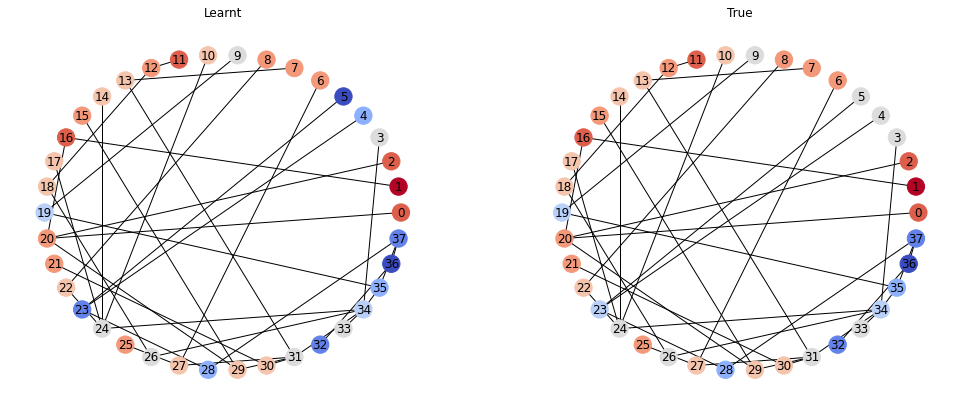

In [ ]:
# Test with various goals

batch = data_list[0].to(DEVICE)

x = batch['x'].clone()

# Add one goal
x[5] = 1.0

print(x.T)
print(batch.y)
print("\n\n")

out = best_model(x, batch['edge_index'], batch['weight'], passes=100)
print(f"Out: {out.T}")


sim, pred = graphs_similarity(batch.y, out, decimals=0)
print(f"Rounded: {pred}")
print(f"Similarity: {sim}")

# ------------------------------------------------------------------
# Plot graphs (more blue = nearer to goal)

# Get graph
G_out = to_networkx(batch, node_attrs=['x', 'y'],
                    to_undirected=True, remove_self_loops=True)    # NOTE: Careful with self loops

fig, ax = plt.subplots(1,2, figsize=(17,7))

# Plots sorted, with lower value being blue
# color_order = np.argsort(np.argsort(out.T.squeeze()))
# color_order = out.T.squeeze()

ax[0].set_title("Learnt")
# pred = out.cpu().detach() if torch.cuda.is_available() else out
nx.draw_circular(G_out, cmap=plt.get_cmap('coolwarm'), node_color=pred, 
                ax=ax[0],
                with_labels=True, font_color='black')

ax[1].set_title("True")
true = batch['y'].cpu().detach() if torch.cuda.is_available() else batch['y']
nx.draw_circular(G_out, cmap=plt.get_cmap('coolwarm'), node_color=true,
                ax=ax[1],
                with_labels=True, font_color='black')

plt.show()

In [ ]:
# Test with various goals

batch = data_list[100].to(DEVICE)

x = batch['x'].clone()

# Add one goal
x[0] = 1.0

print(x.T)
print(batch.y)
print("\n\n")

out = best_model(x, batch['edge_index'], batch['weight'], passes=10)
print(f"Out: {out.T}")


sim, pred = graphs_similarity(batch.y, out, decimals=0)
print(f"Rounded: {pred}")
print(f"Similarity: {sim}")

# ------------------------------------------------------------------
# Plot graphs (more blue = nearer to goal)

# Get graph
G_out = to_networkx(batch, node_attrs=['x', 'y'],
                    to_undirected=True, remove_self_loops=True)    # NOTE: Careful with self loops

fig, ax = plt.subplots(1,2, figsize=(17,7))

# Plots sorted, with lower value being blue
# color_order = np.argsort(np.argsort(out.T.squeeze()))
# color_order = out.T.squeeze()

ax[0].set_title("Learnt")
# pred = out.cpu().detach() if torch.cuda.is_available() else out
nx.draw_circular(G_out, cmap=plt.get_cmap('coolwarm'), node_color=pred, 
                ax=ax[0],
                with_labels=True, font_color='black')

ax[1].set_title("True")
true = batch['y'].cpu().detach() if torch.cuda.is_available() else batch['y']
nx.draw_circular(G_out, cmap=plt.get_cmap('coolwarm'), node_color=true,
                ax=ax[1],
                with_labels=True, font_color='black')

plt.show()

# Load saved model

In [ ]:
best_model = ACGNN(input_dim=1,
                    hidden_dim=1,
                    output_dim=1,
                    aggregate_type="min",
                    combine_type="mlp", #"mlp","simple"
                    combine_layers=0,
                    num_mlp_layers=2,
                    #   task="node"
                    final_mlp=False,
                ).to(DEVICE)

In [ ]:
path = 'acgnn-with-relu.model'
best_model.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))

In [ ]:
best_model.state_dict()

OrderedDict([('conv.mlp.linears.0.weight', tensor([[-0.0448,  1.1758],
                      [-1.6313,  0.0310]], device='cuda:0')),
             ('conv.mlp.linears.0.bias',
              tensor([-1.0913,  2.2279], device='cuda:0')),
             ('conv.mlp.linears.1.weight',
              tensor([[-0.3653,  1.5668]], device='cuda:0')),
             ('conv.mlp.linears.1.bias', tensor([1.0093], device='cuda:0'))])

# Road maps

In [ ]:
%%capture

# OSMnx (OpenStreetMap Python API)
!pip install osmnx

!pip install -U matplotlib

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas
import pandas as pd

# import pickle

from torch_geometric.utils import to_networkx

import time

## Utils

In [ ]:
def remove_attributes(G):
    # DON'T EXECUTE WHILE TESTING, ONLY TO GET FINAL GRAPH

    # Edge attributes to remove
    att_list = [
        "maxspeed",
        'from',
        'to',
        'osmid',
        'ref',

        'width',
        "junction",
        "access",
        "tunnel",
        "lanes",
        "geometry",
        "bridge",
        "highway",
        "name",
        "oneway",
        "service"
    ]

    for _, _, d in G.edges(data=True):
        for att in att_list:
            d.pop(att, None)

    # Node attributes to remove
    att_list = [
        "ref",

        "highway",
        "street_count",
        # "x",  # Don't remove in RL
        # "y"   # Don't remove in RL
    ]

    for _, d in G.nodes(data=True):
        for att in att_list:
            d.pop(att, None)

    return G

def preprocess_graph(G):
    G_nx = nx.relabel.convert_node_labels_to_integers(G)
    # nodes, edges = ox.graph_to_gdfs(G_nx, nodes=True, edges=True)

    G_nx = remove_attributes(G_nx)

    # Set node attributes (type and time windows)
    # G_nx = set_node_attributes(G_nx)

    # Remove nodes with no output road
    # G_nx = remove_deadends(G_nx)

    # Add speed to edges
    # G_nx = set_graph_speed(G_nx)

    return G_nx

# ------------------------------------------------------------------------------

def remove_deadends(G):
    # Iterate until empty
    no_out = list(node for node, out_degree in G.out_degree() if out_degree == 0)
    while no_out:
      G.remove_nodes_from(no_out)
      G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

      no_out = list(node for node, out_degree in G.out_degree() if out_degree == 0)

    return G

In [ ]:
def plot_map(G, plot_node_types=False):
    if plot_node_types:
        gdf_nodes, _ = ox.graph_to_gdfs(G, nodes=True)

        # color_map = {0: 'k', 1: 'c', 2: 'y', 3: 'g'}
        color_map = {0: 'w', 1: 'c', 2: 'y', 3: 'g'}

        colors = gdf_nodes['type']
        colors = colors.replace(color_map)
    else:
        colors='w'

    fig, ax = ox.plot_graph(G,
                            figsize=(20,17),
                            node_color=colors,
                            # bgcolor='white',
                            show=False, close=False)
    
    return fig, ax

# ------------------------------------------------------------------------------

def plot_path(G, source, target, paths, rc=['r'], base_map_ax=None):
    # Plot
    if len(paths) == 1:
        fig, ax = ox.plot_graph_route(G, paths[0],
                                    route_color=rc[0],
                                    figsize=(20,17),
                                    ax=base_map_ax,   # Plot on existing graph
                                    show=False, close=False) # OSMnx closes and
                                                            # shows by default
    else:
        fig, ax = ox.plot_graph_routes(G, paths,
                                    route_colors=rc,
                                    figsize=(20,17),
                                    ax=base_map_ax,   # Plot on existing graph
                                    show=False, close=False) # OSMnx closes and
                                                            # shows by default

    gdf_nodes, _ = ox.graph_to_gdfs(G, nodes=True)

    # Plot start, current and target node
    gdf_nodes.iloc[
            [source]
        ].plot(ax=ax, color='hotpink', markersize=200, marker="v")

    # gdf_nodes.iloc[
    #     [self.current_node]
    # ].plot(ax=ax, color='hotpink', markersize=200, marker="P")

    gdf_nodes.iloc[
        [target]
    ].plot(ax=ax, color='hotpink', markersize=300, marker="*")


    return fig

# ------------------------------------------------------------------------------

# Plot heatmmap
def plot_heatmap(G_out, G_original, attr="y"):
    # get node colors by linearly mapping an attribute's values to a colormap
    nc = ox.plot.get_node_colors_by_attr(G_out, attr=attr, cmap='plasma', num_bins=10)
    fig, ax = ox.plot_graph(G_original,
                            node_color=nc,
                            node_size=150,
                            figsize=(20,17))
                            # show=False, close=False) # OSMnx closes and
                                                    # shows by default

    return fig




# fig, ax = ox.plot_graph(G, figsize=(70,57), show=False, close=False)
# for id, node in ox.graph_to_gdfs(G, edges=False).iterrows():
#     if (id % 3) == 0:
#         text = id
#         c = node["geometry"].centroid
#         ax.annotate(text, (c.x, c.y), c="y")
# plt.show()

In [ ]:
def test_graph(model, G):
    G = preprocess_graph(G)

    # To undirected
    G = G.to_undirected()

    # Copy for plotting
    G_original = G.copy()

    num_nodes = G.number_of_nodes()

    # --------------------------------------------------------------------------
    # Get base map plot
    # _, base_map_ax = plot_map(G)

    # pickle.dump(base_map_ax, open('base_map.pkl', 'wb'))

    # --------------------------------------------------------------------------
    _ = ox.plot_graph(G_original,figsize=(20,17))

    # --------------------------------------------------------------------------
    # Select random target node
    # target = np.random.randint(0, number_of_nodes)
    target = 0

    # Find shortest path length based on 'length' for each node
    start = time.time()
    paths = nx.shortest_path_length(G, source=None, target=target,
                                    # weight='length',
                                    method='dijkstra')
    true_time = (time.time() - start)

    # Set node attribute 'y' to that value for each node
        # set_graph_label(G, paths)
    for k, v in paths.items():
        G.nodes(data=True)[k]['y'] = v +1


    # Set passes as the eccentricity of the graph
    ecc = nx.eccentricity(G, v=target)
    passes = int(ecc*3)

    # ----------------------------------------------------------------------
    # x
    # ----------------------------------------------------------------------
    # Set node attribute 'x' to 2
    # nx.set_node_attributes(G, 2.0, 'x') # Must be bigger than data.y.max()
    
    # Set random bigger than 2
    values = np.random.uniform(low=2.0, high=ecc, size=num_nodes)

    # Rest get random value                      
    for n, v in enumerate(values):
        G.nodes(data=True)[n]['x'] = float(v)


    # Set initial value of target as 1
    G.nodes(data=True)[target]['x'] = 1.0

    # --------------------------------------------------------------------------
    # Get graph as tensor
    G.graph = {} # from_networkx can't receive non-string global arguments

    data = from_networkx(G, group_node_attrs=['x']).to(DEVICE)

    # --------------------------------------------------------------------------
    # Forward pass
    with torch.no_grad():
        start = time.time()
        # out = model(data['x'].float(), data['edge_index'], passes=passes)
        out = model(data['x'].float(), data['edge_index'], data['length'].float(), passes=passes)
        pred_time = (time.time() - start)

    out = out.T.squeeze()

    # Loss
    loss_fn = nn.L1Loss()
    loss = loss_fn(out.T.squeeze(), data['y'])
    print(f"Loss: {loss}")

    print(f"True time: {true_time}")
    print(f"Pred time: {pred_time}")
    print(f"Diff time: {(true_time - pred_time) * 100}")

    # --------------------------------------------------------------------------
    # Plot histogram of output
    pred = out.cpu().numpy() if torch.cuda.is_available() else out.numpy()
    true = data.y.cpu().numpy() if torch.cuda.is_available() else data.y.numpy()

    plt.hist(pred, color="b", alpha=0.5, label="out")
    plt.hist(true, color="g", alpha=0.5, label="y")

    plt.legend(loc='upper right')

    # ----------------------------------------------------------------------
    # Transform output to graph
    data['out'] = out

    data['diff'] = torch.abs(data.y - out)

    G_out = to_networkx(data, node_attrs=['out', 'y', 'diff'],
                    to_undirected=True, remove_self_loops=True)    # NOTE: Careful with self loops


    # --------------------------------------------------------------------------
    print("Learnt graph")
    _ = plot_heatmap(G_out, G_original, "out")

    # --------------------------------------------------------------------------
    print("True graph")
    _ = plot_heatmap(G_out, G_original, "y")

    # --------------------------------------------------------------------------
    print("Differences")
    _ = plot_heatmap(G_out, G_original, "diff")

    return data

## Test

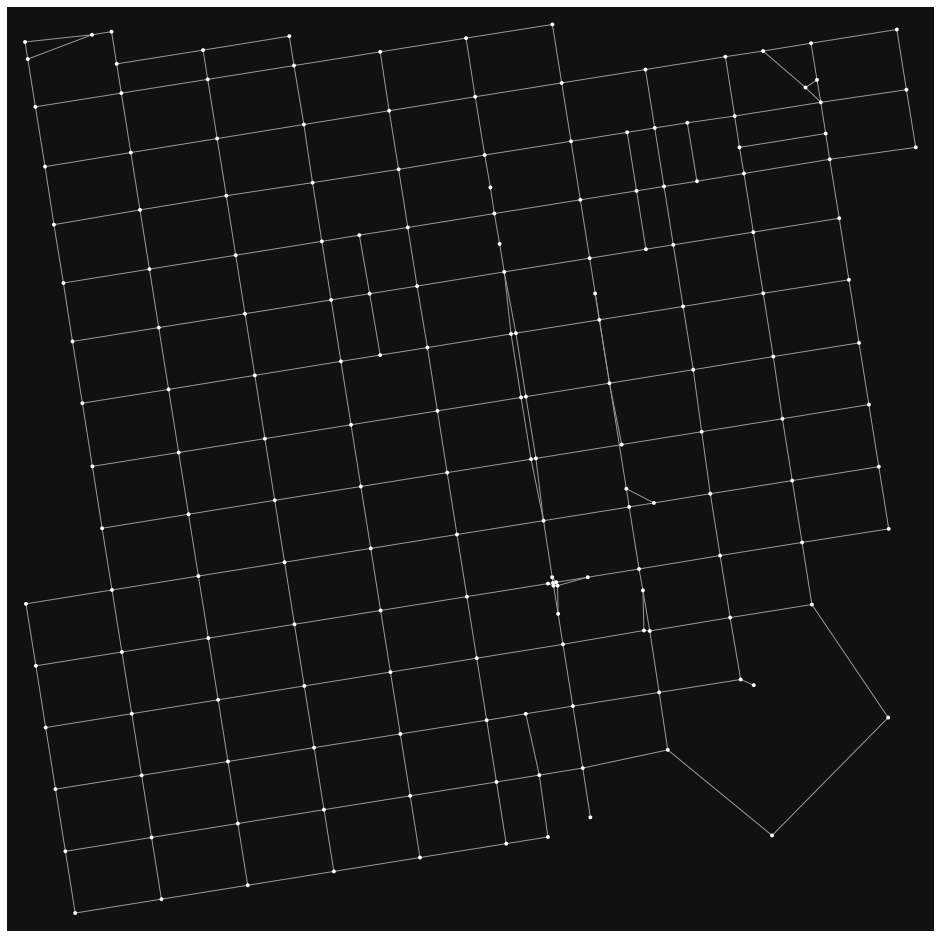

Loss: 0.7154783010482788
True time: 0.0005061626434326172
Pred time: 0.023758649826049805
Diff time: -2.3252487182617188
Learnt graph


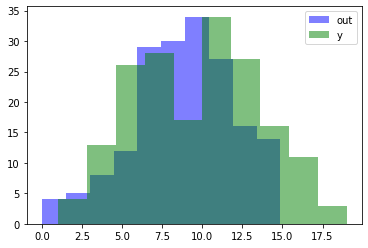

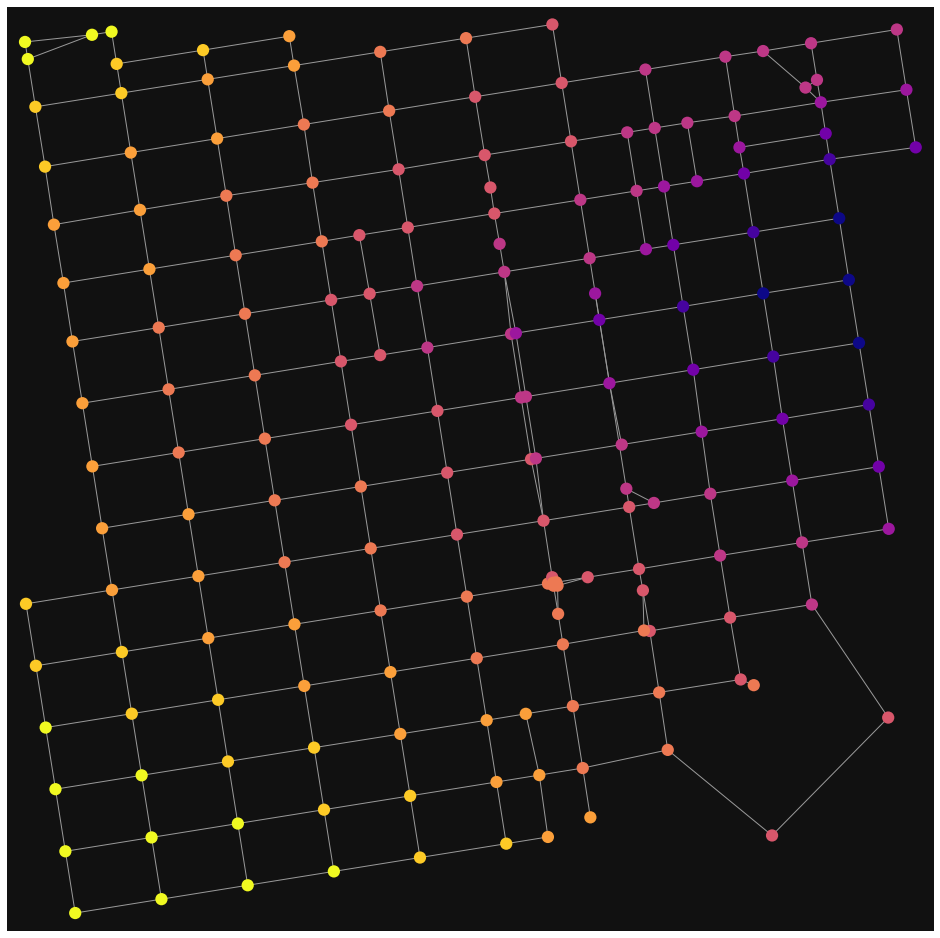

True graph


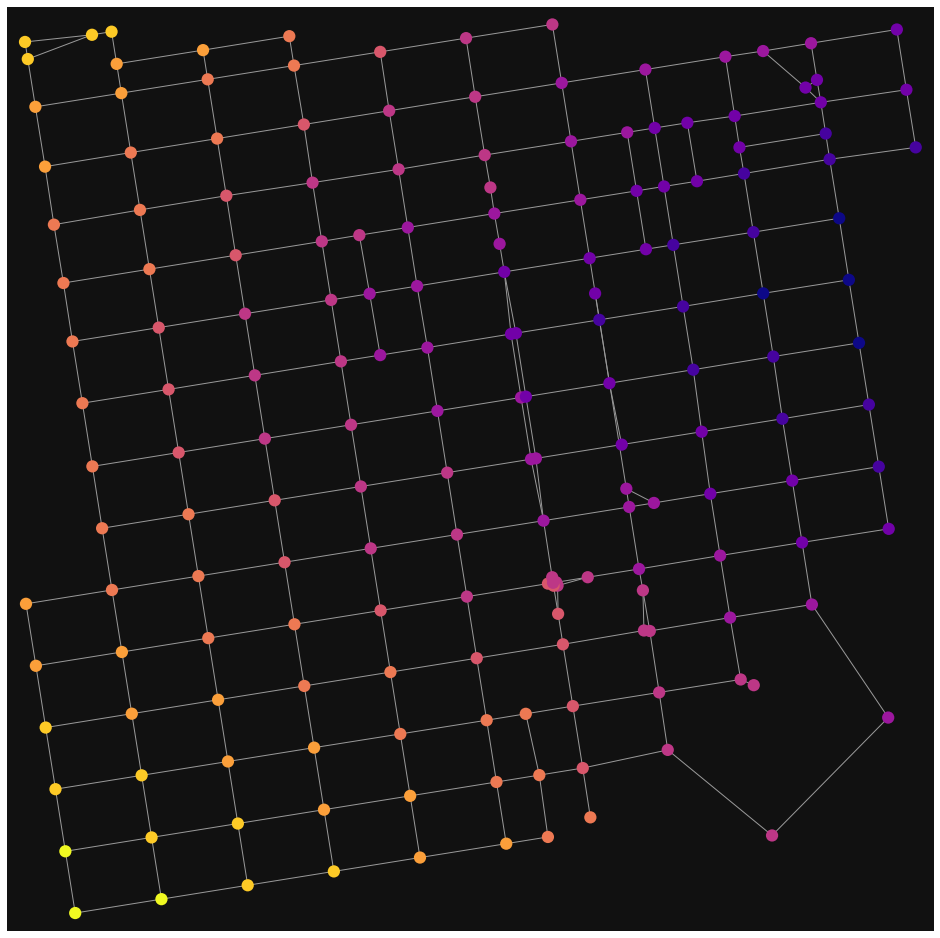

Differences


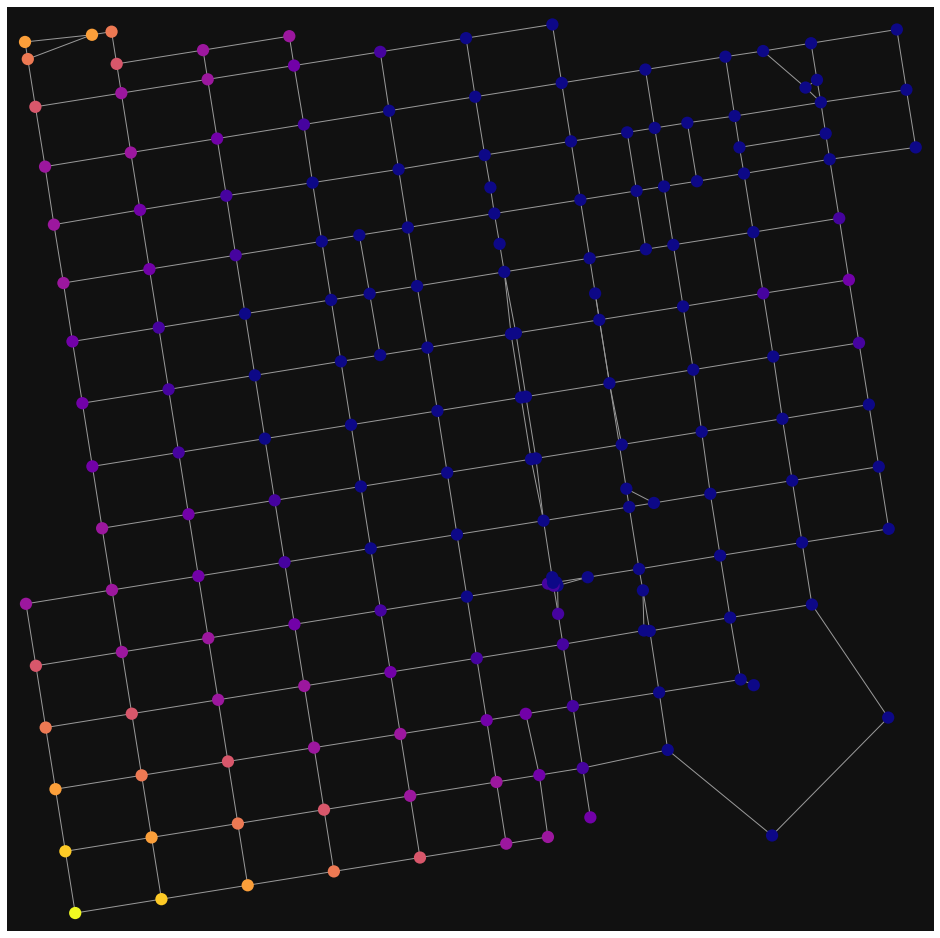

In [ ]:
# San Francisco
# G_1 = ox.graph_from_point((37.79, -122.41), dist=750, network_type="drive")

graph_path = 'city-sanFrancisco.graphml'
G_1 = ox.load_graphml(graph_path)

# test_graph(best_model, G_1)
data = test_graph(best_model, G_1)

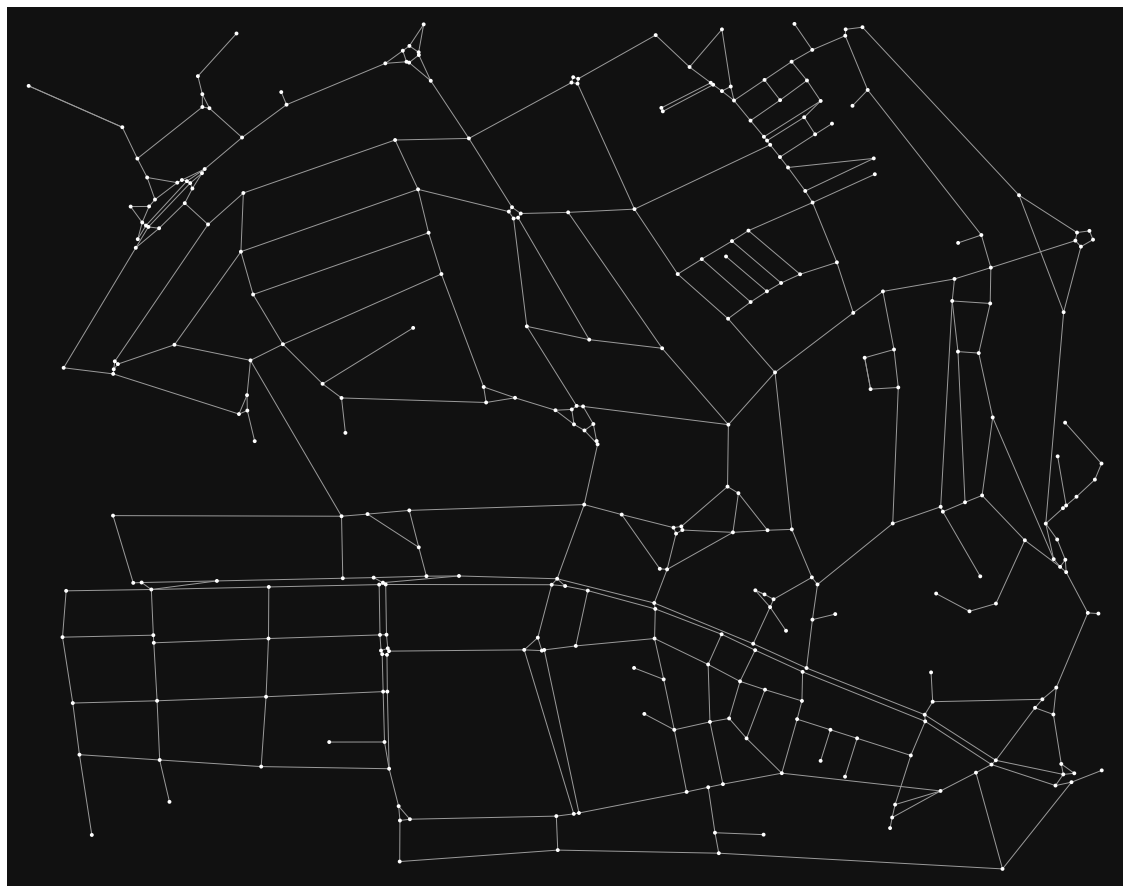

Loss: 0.8842945694923401
True time: 0.0008552074432373047
Pred time: 0.031949758529663086
Diff time: -3.109455108642578
Learnt graph


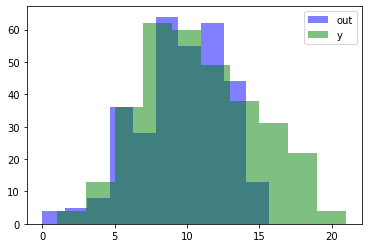

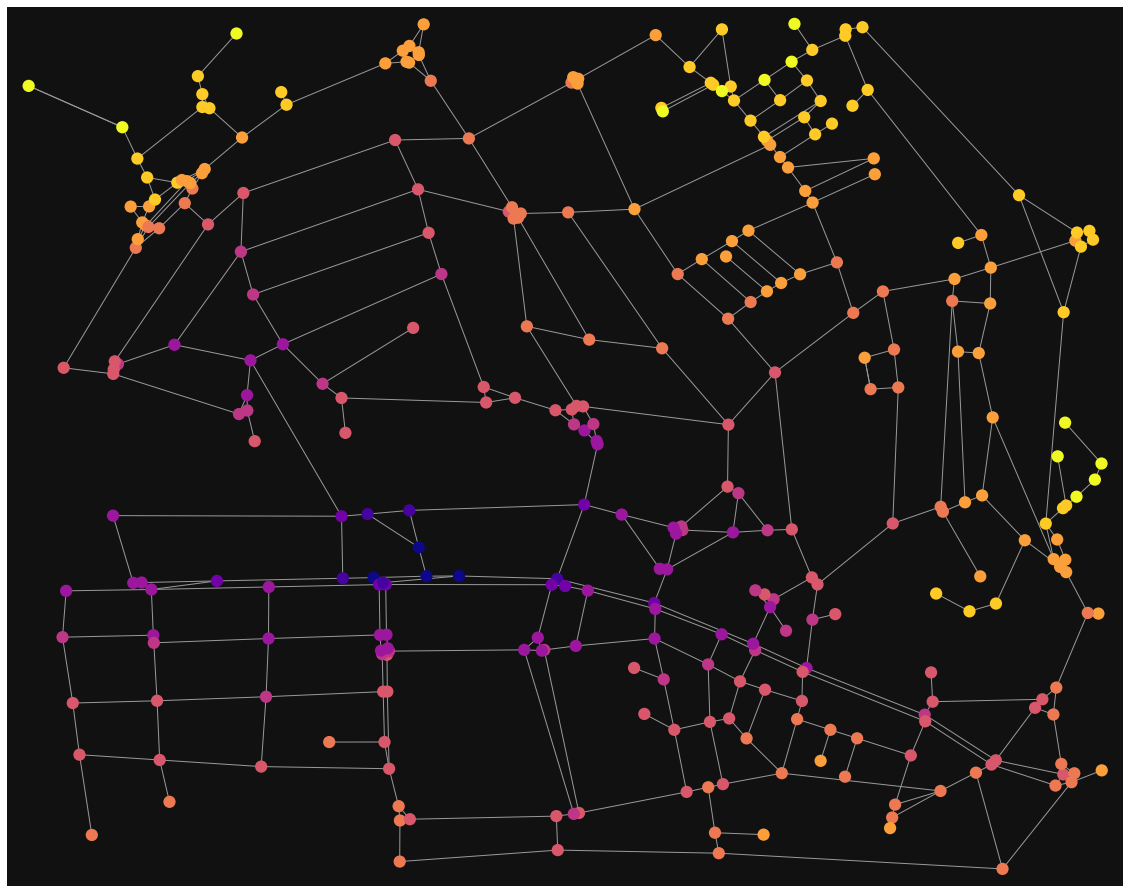

True graph


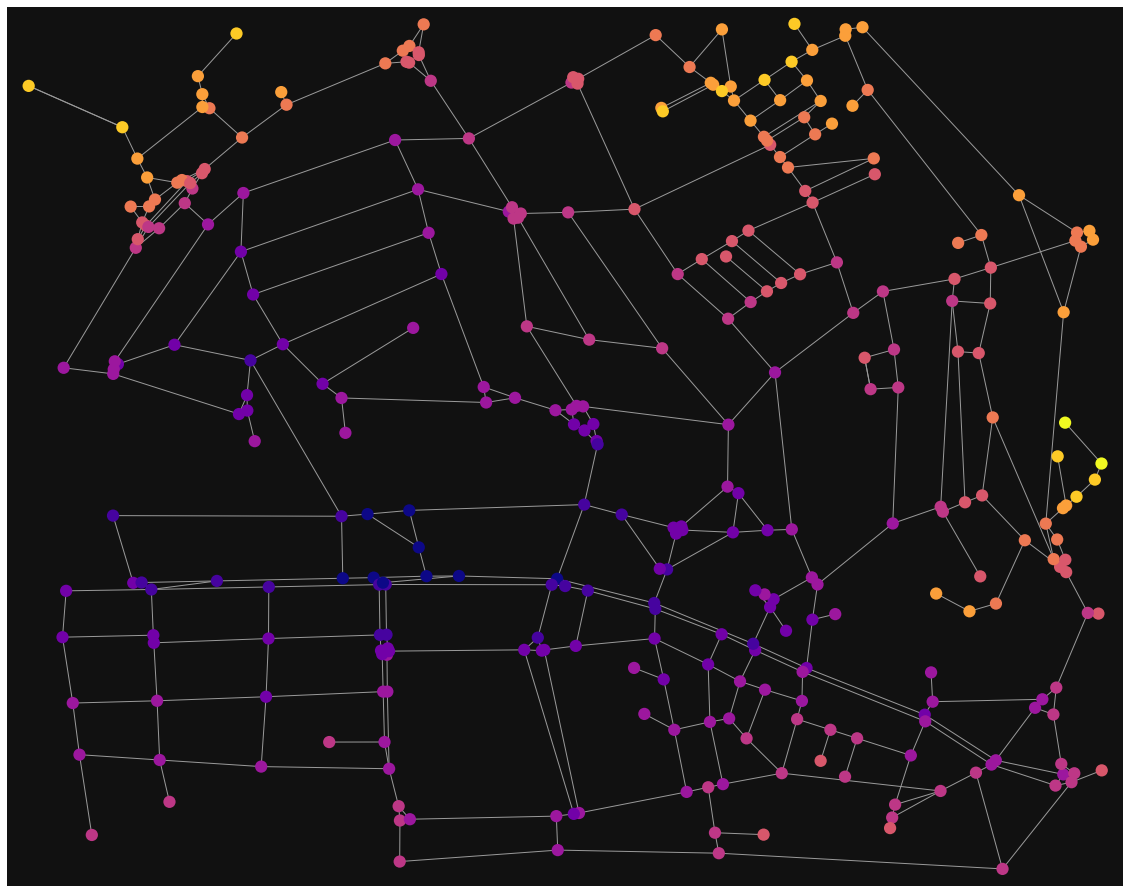

Differences


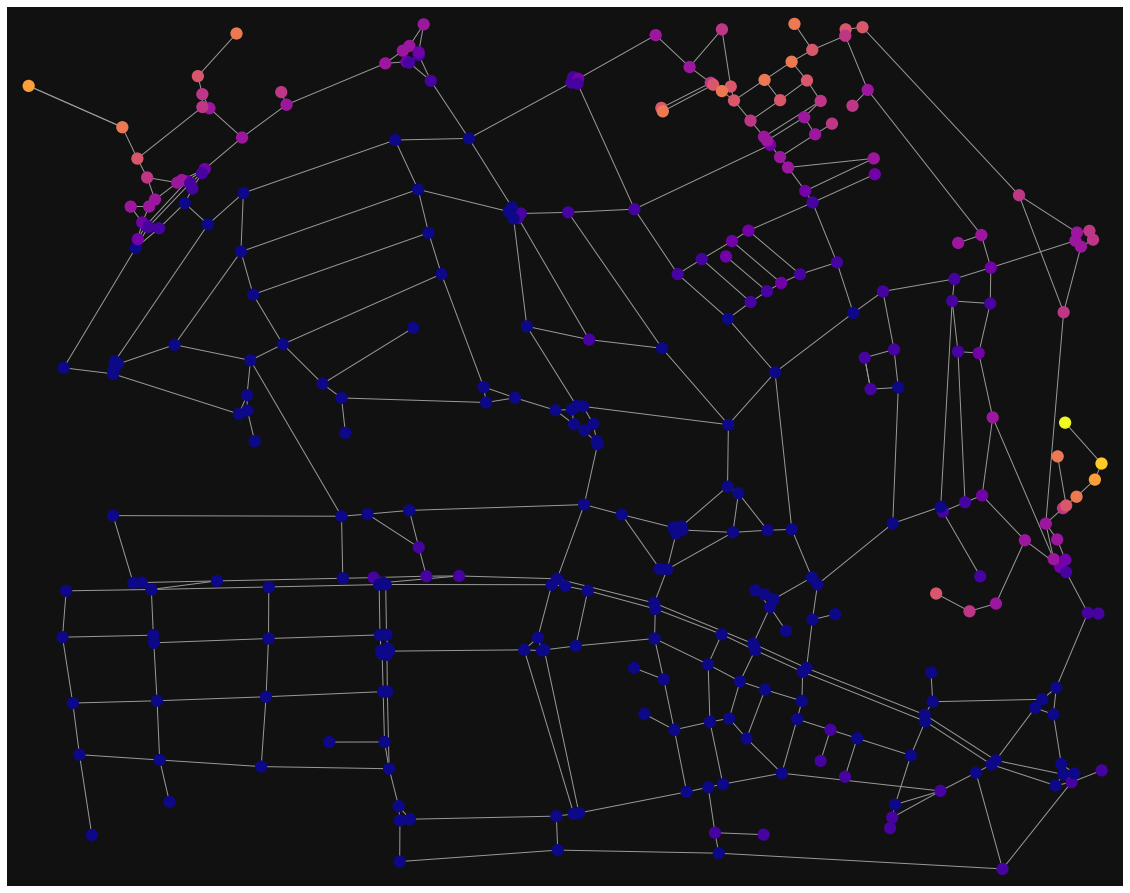

In [ ]:
# Marbella
# G_2 = ox.graph_from_place('Marbella, Spain', network_type='drive')
# G_2 = ox.graph_from_point((36.51044, -4.89053), dist=750, network_type="drive")

graph_path = 'city-marbella.graphml'
G_2 = ox.load_graphml(graph_path)

_ = test_graph(best_model, G_2)

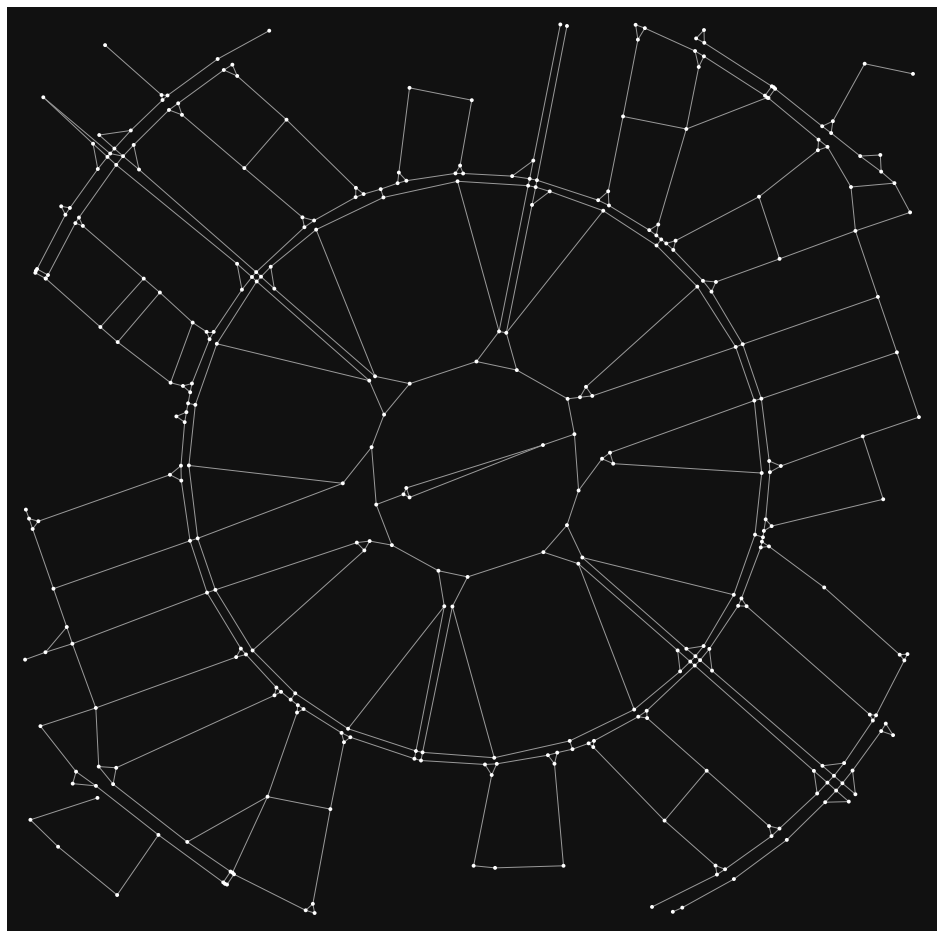

Loss: 7.677817344665527
True time: 0.001149892807006836
Pred time: 0.020360946655273438
Diff time: -1.9211053848266602
Learnt graph


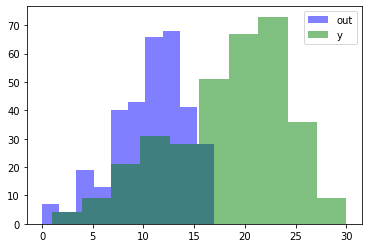

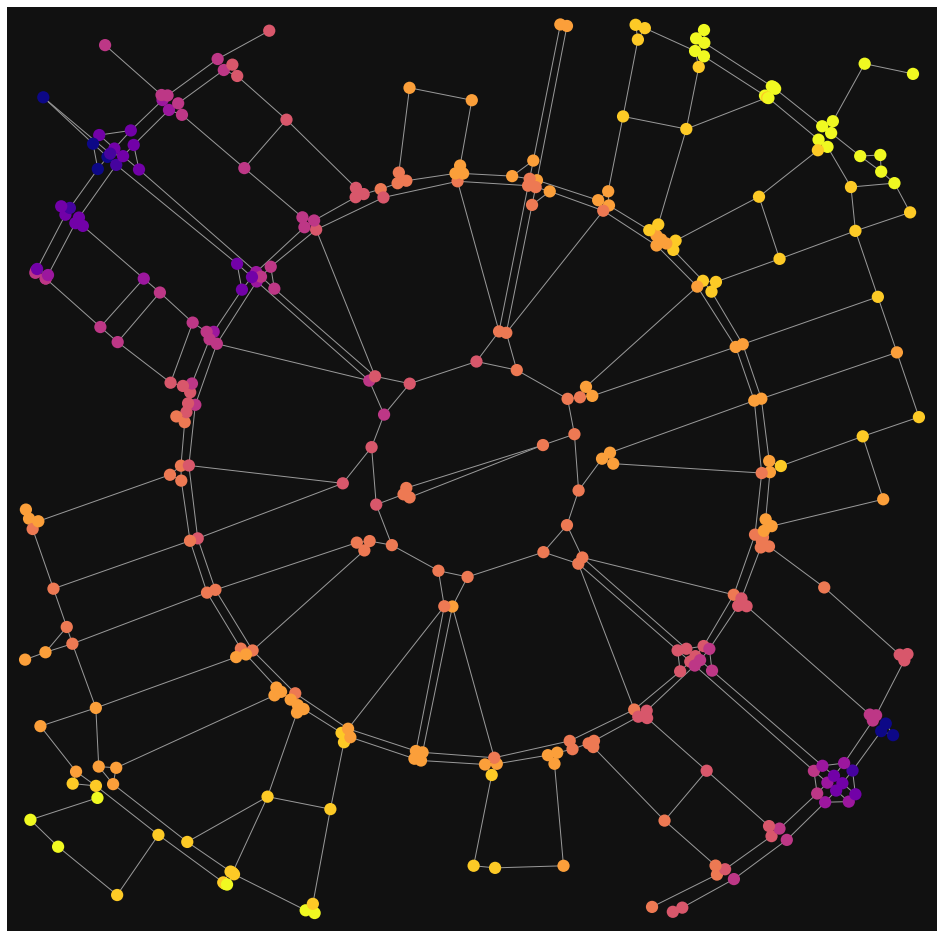

True graph


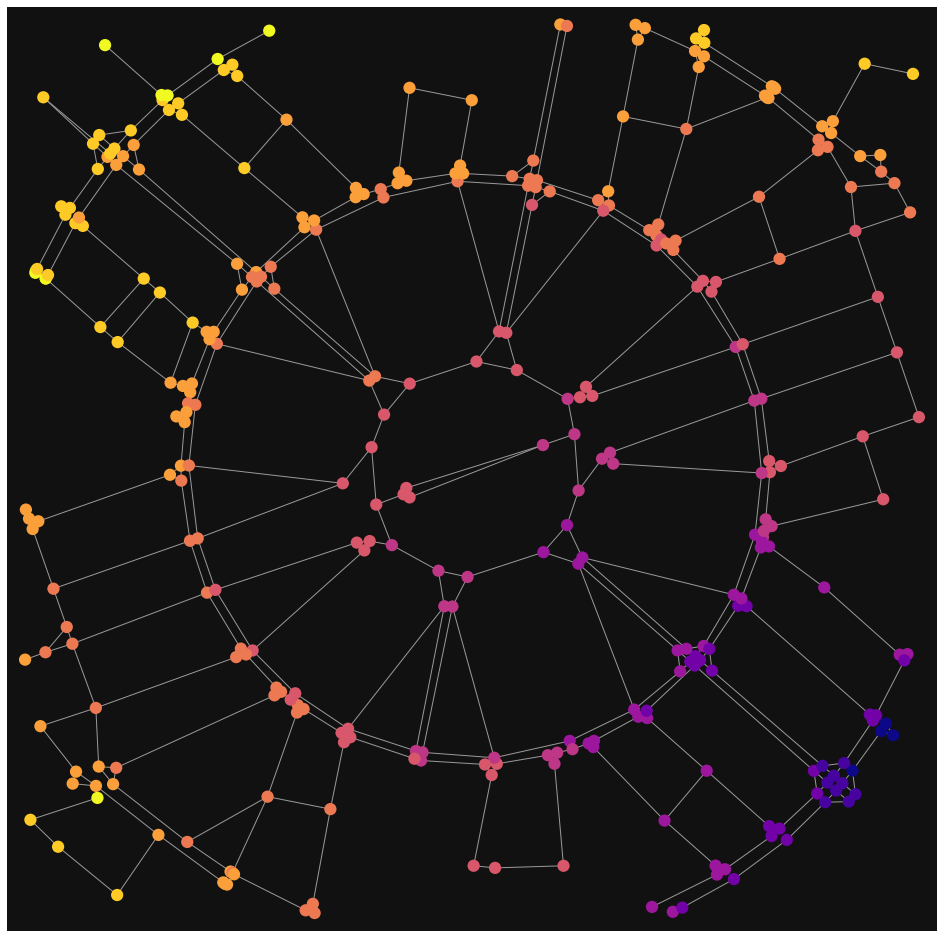

Differences


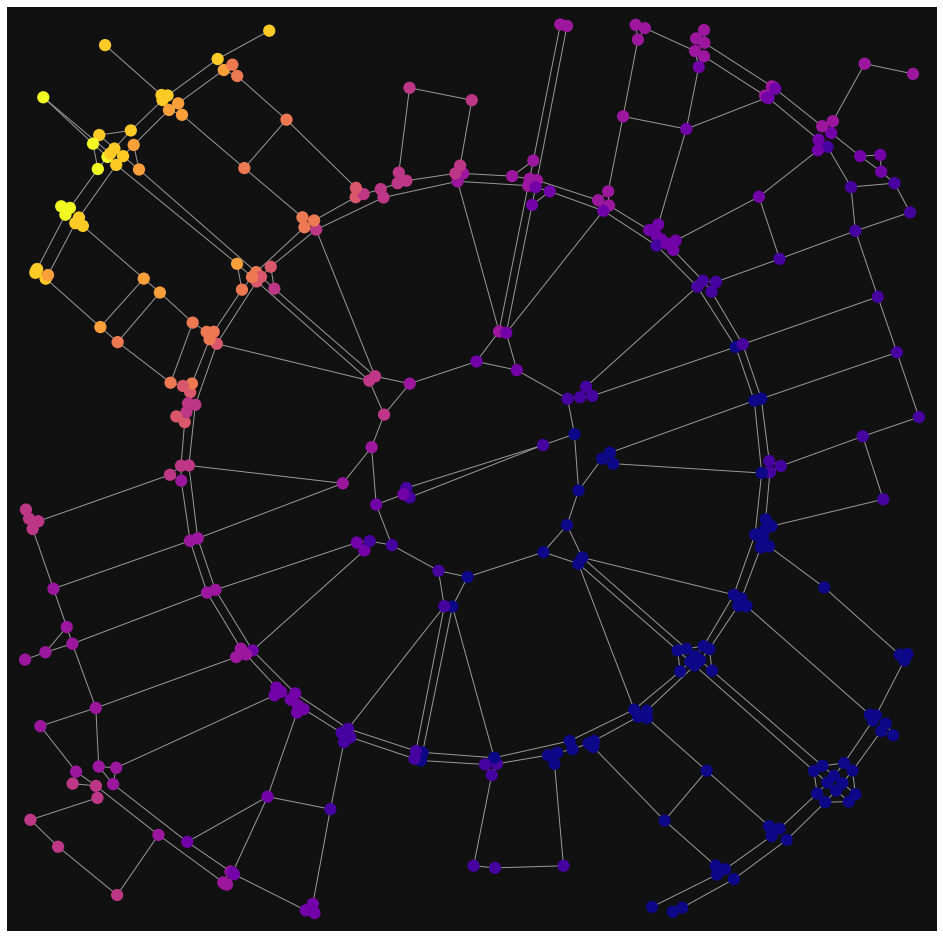

In [ ]:
# Dubai
# G_3 = ox.graph_from_place('Dubai, United Arab Emirates', network_type='drive')
# G_3 = ox.graph_from_point((25.0566, 55.2079), dist=750, network_type="drive")

graph_path = 'city-dubai.graphml'
G_3 = ox.load_graphml(graph_path)

_ = test_graph(best_model, G_3)

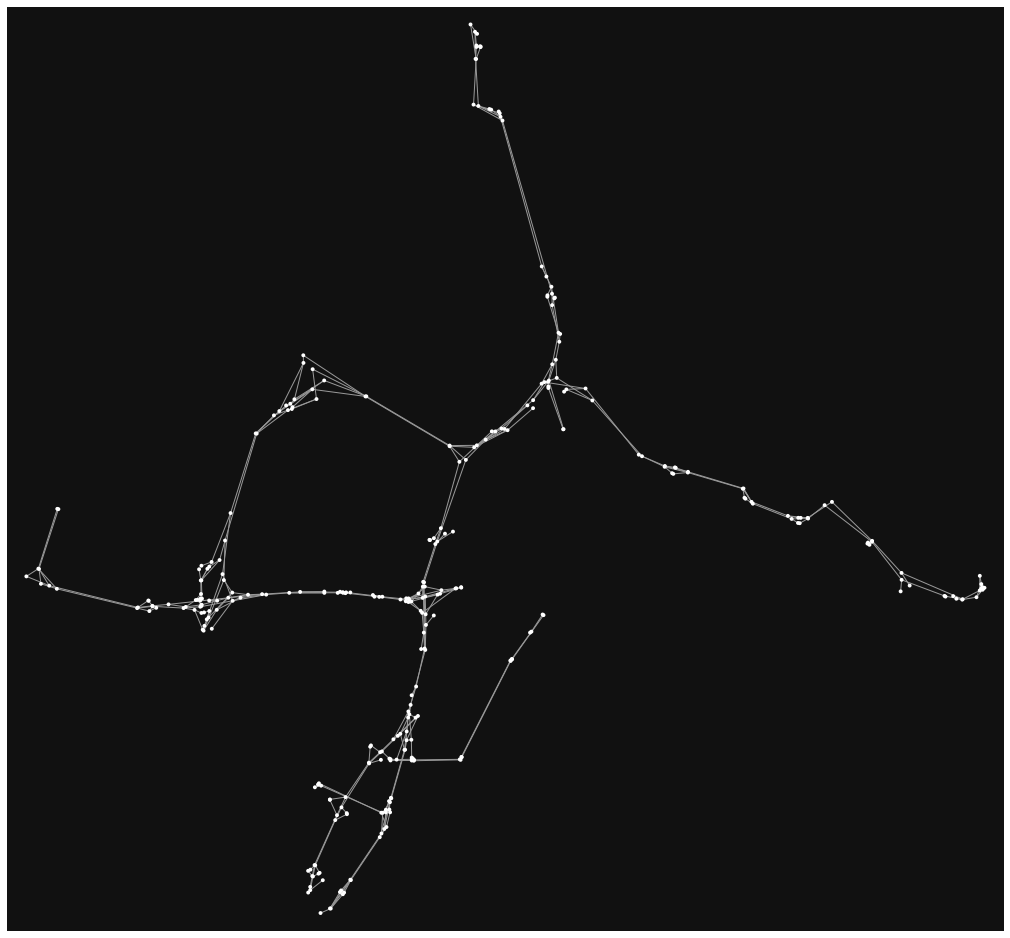

Loss: 1.5069068670272827
True time: 0.0009076595306396484
Pred time: 0.010885238647460938
Diff time: -0.9977579116821289
Learnt graph


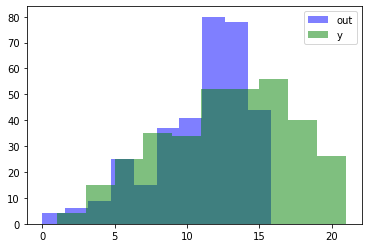

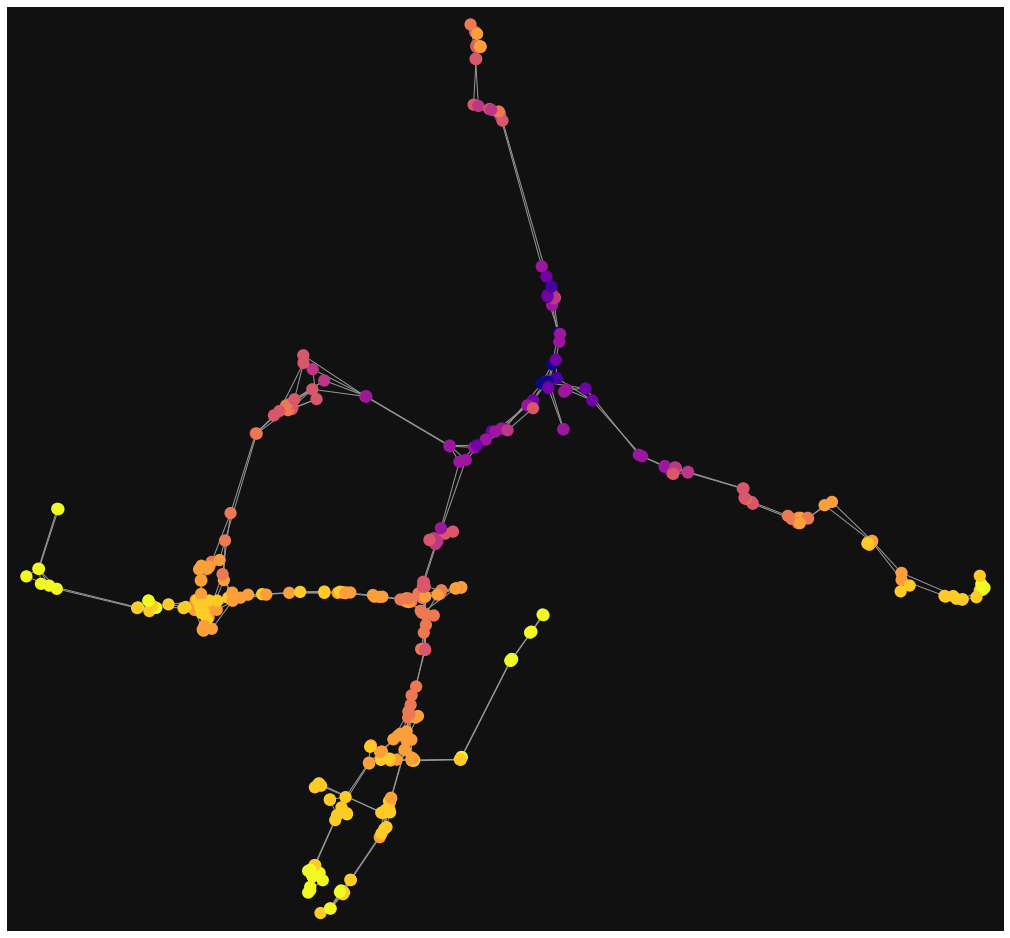

True graph


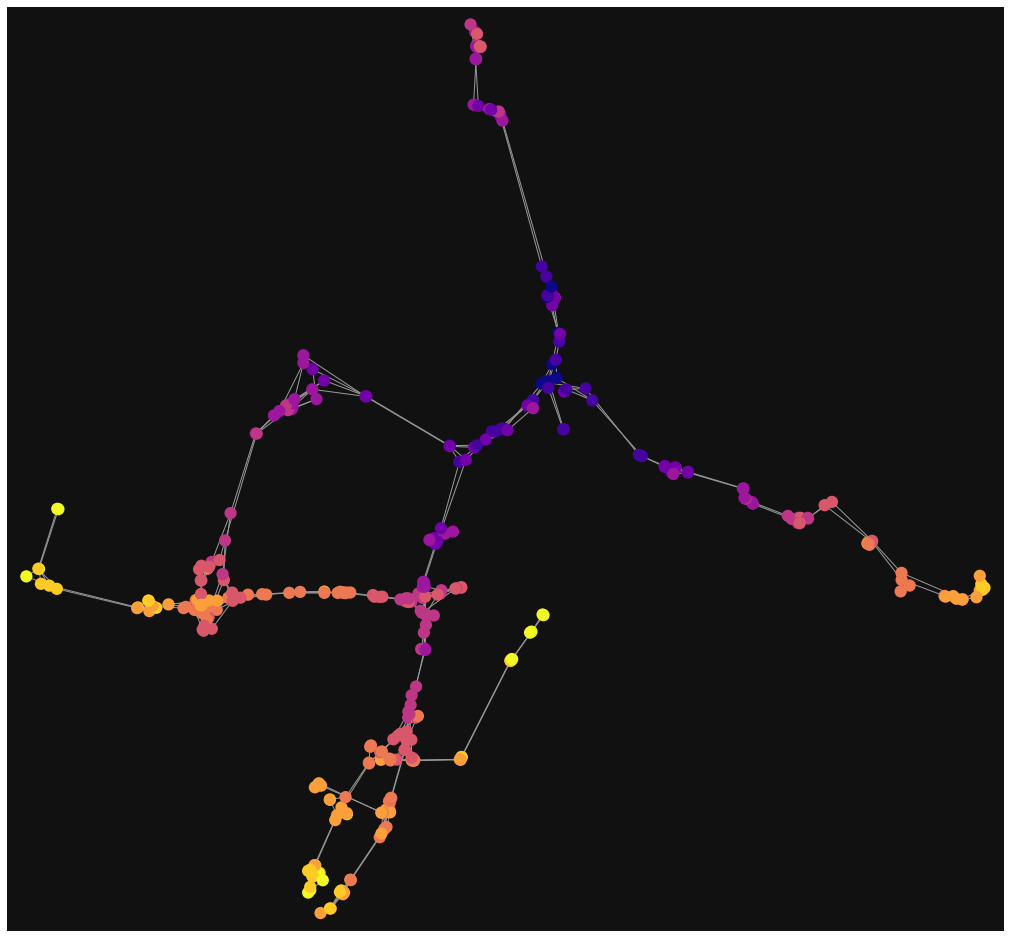

Differences


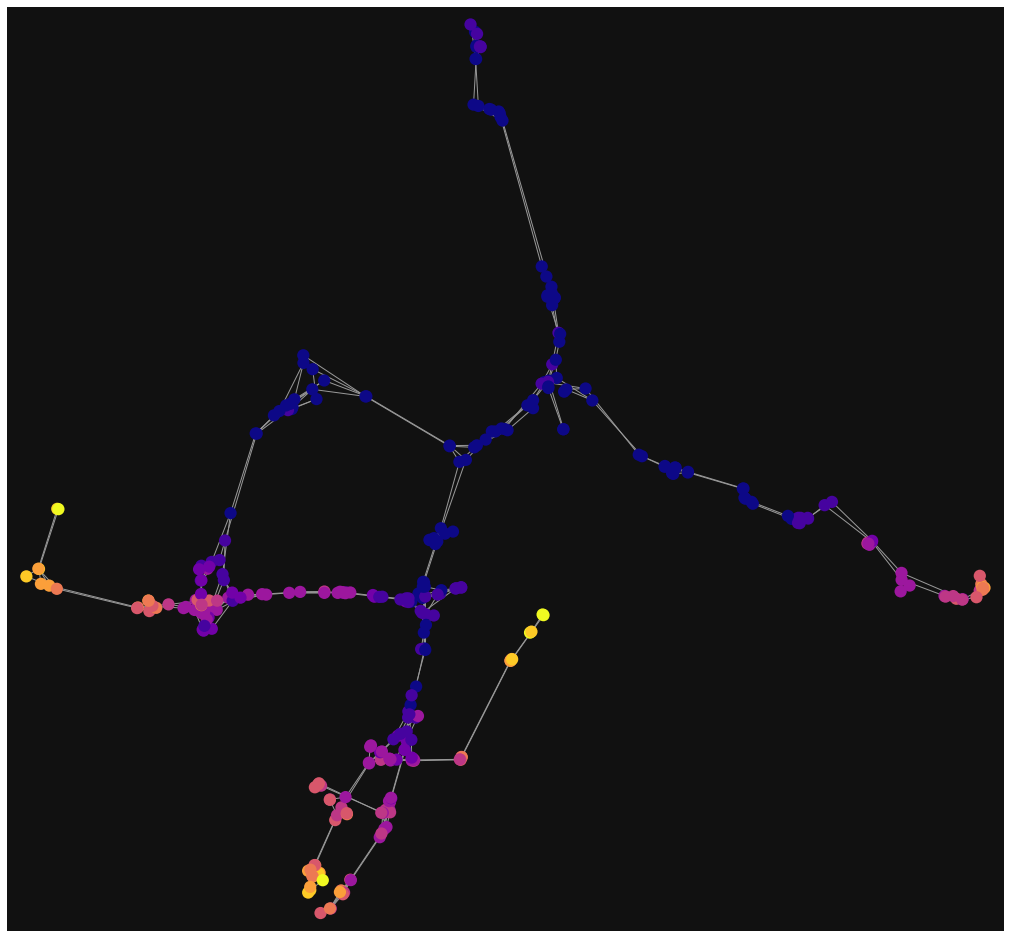

In [ ]:
# Malaga
# filter = '["highway"~"motorway|motorway_link|trunk|trunk_link"]'
# G_4 = ox.graph_from_place("Malaga", network_type='drive',
#                         simplify=True, custom_filter=filter)

# _ = ox.plot_graph(G_4,figsize=(20,17))

graph_path = 'road-malaga.graphml'
G_4 = ox.load_graphml(graph_path)

# ------------------------------------------------------------------------------
_ = test_graph(best_model, G_4)

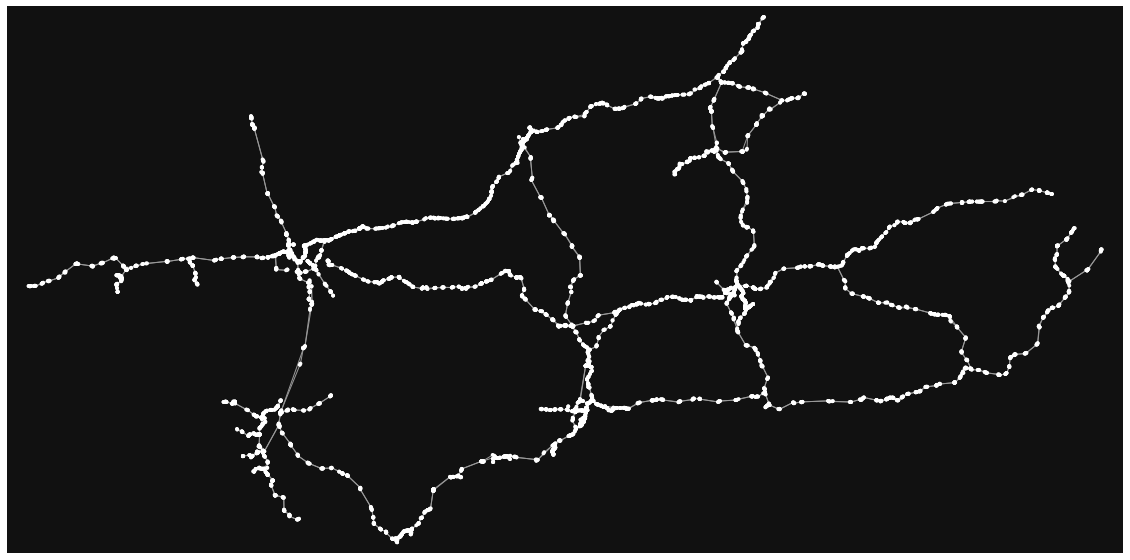

Loss: nan
True time: 0.009850740432739258
Pred time: 0.18824291229248047
Diff time: -17.83921718597412


ValueError: ignored

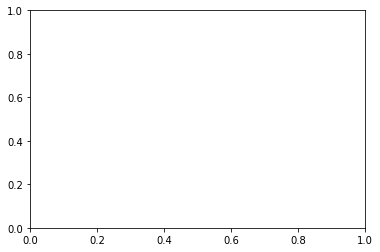

In [ ]:
graph_path = 'andalusia-raw.graphml'

G_5 = ox.load_graphml(graph_path)

# ------------------------------------------------------------------------------
data = test_graph(best_model, G_5)

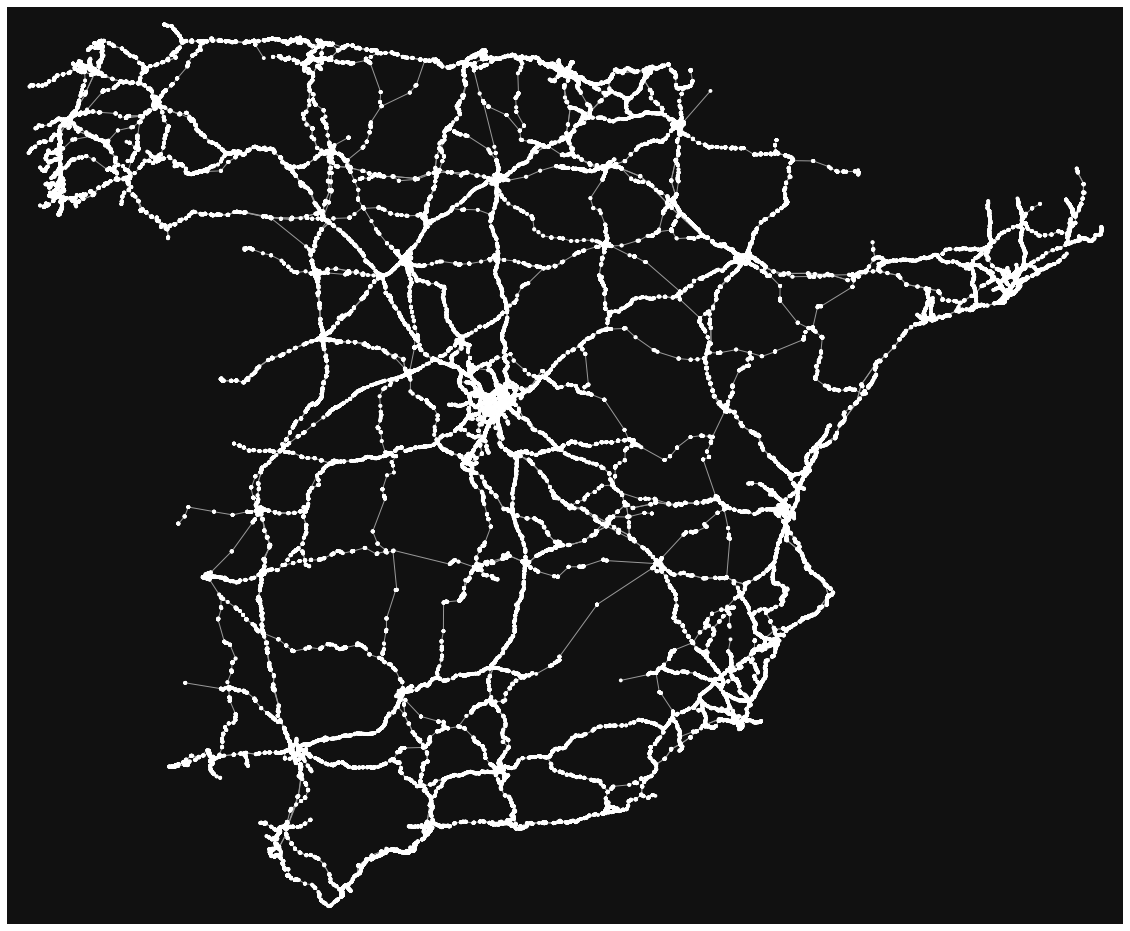

Loss: 297.2393798828125
True time: 0.11014270782470703
Pred time: 0.38324713706970215
Diff time: -27.31044292449951
Learnt graph


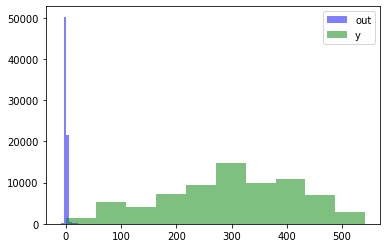

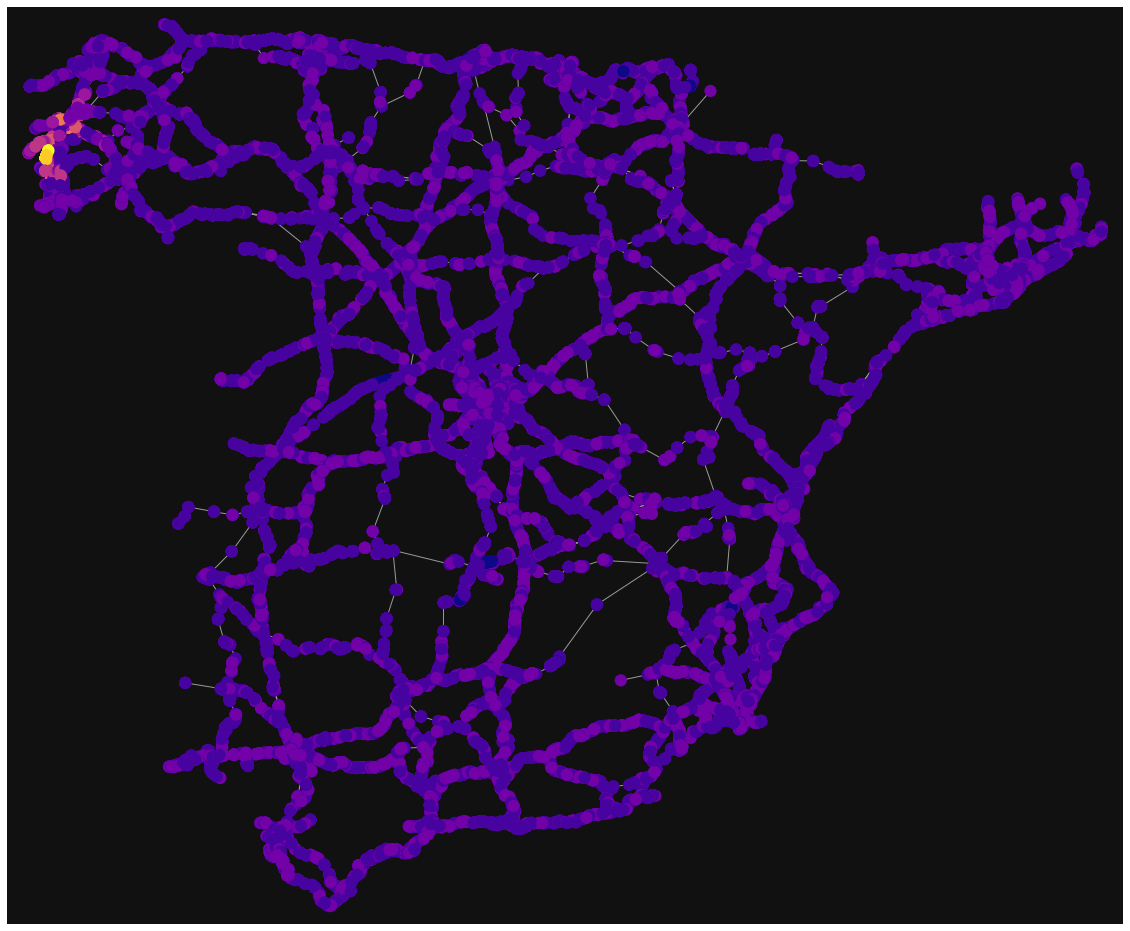

True graph


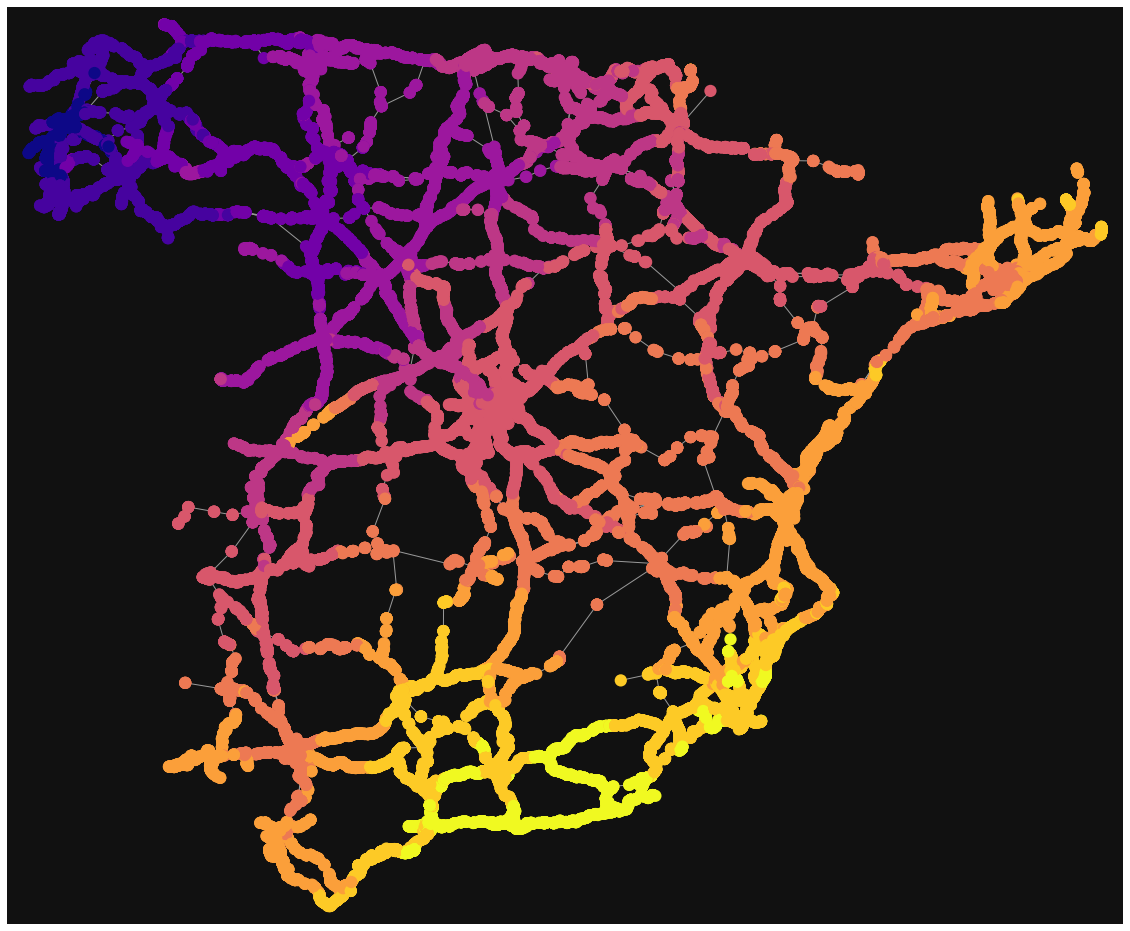

Differences


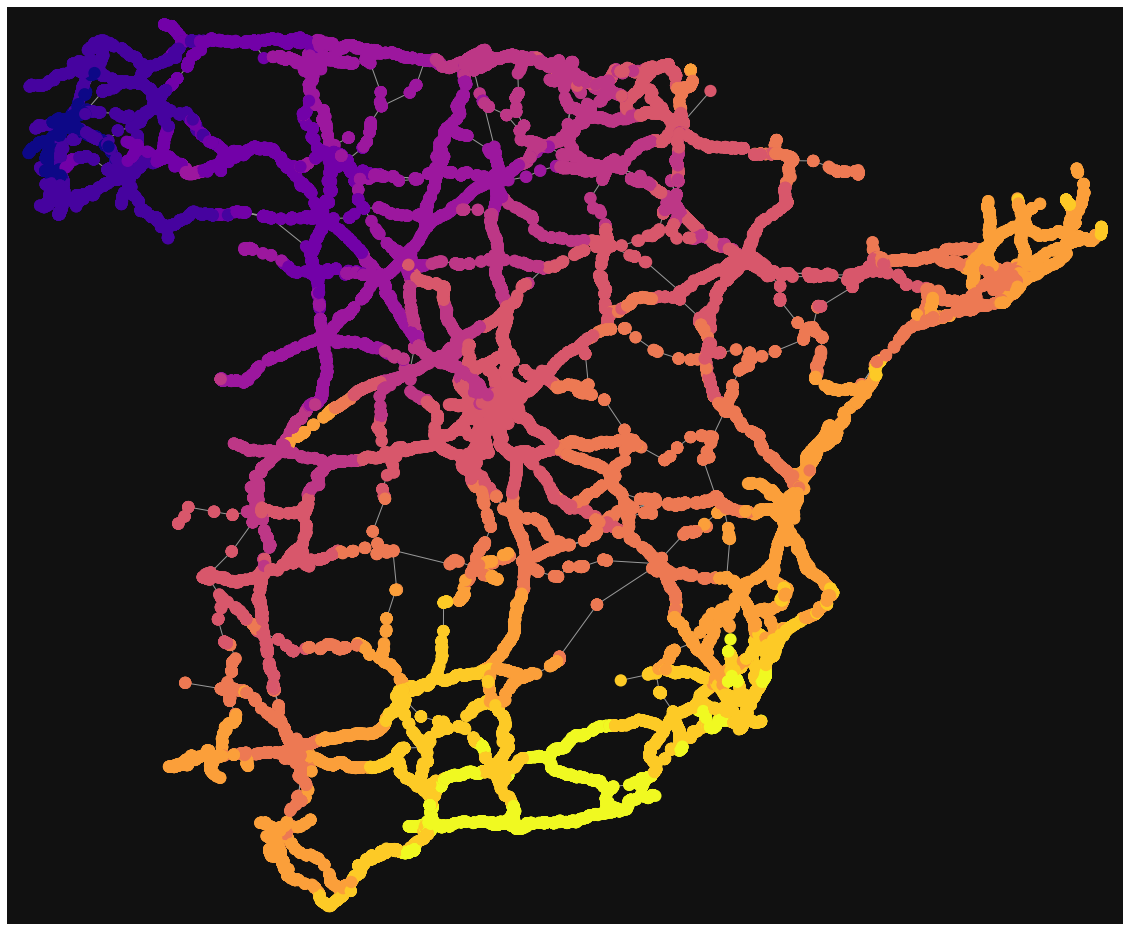

In [ ]:
graph_path = 'spain-raw.graphml'

G_6 = ox.load_graphml(graph_path)

# ------------------------------------------------------------------------------
_ = test_graph(best_model, G_6)

## No in function

In [ ]:
G = preprocess_graph(G_6)

# To undirected
G = G.to_undirected()

# Copy for plotting
G_original = G.copy()

number_of_nodes = G.number_of_nodes()

# ------------------------------------------------------------------------------
# Get base map plot
# _, base_map_ax = plot_map(G)

# pickle.dump(base_map_ax, open('base_map.pkl', 'wb'))

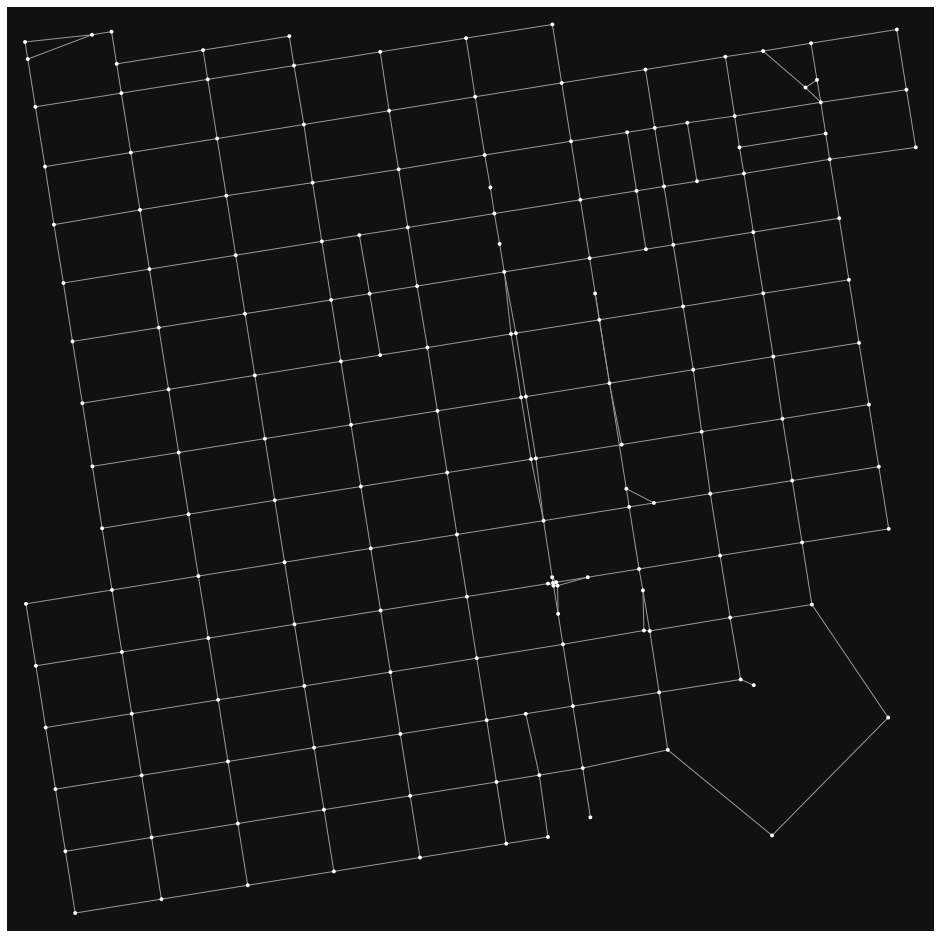

In [ ]:
_ = ox.plot_graph(G_original,figsize=(20,17))

In [ ]:
# Select random target node
# target = np.random.randint(0, number_of_nodes)
target = 0

# Find shortest path length based on 'length' for each node
start = time.time()
paths = nx.shortest_path_length(G, source=None, target=target,
                                weight='length', method='dijkstra')
print(f"Dijkstra: {time.time() - start}")

# Set node attribute 'y' to that value for each node
    # set_graph_label(G, paths)
for k, v in paths.items():
    G.nodes(data=True)[k]['y'] = v +1


# Set passes as the eccentricity of the graph
passes = nx.eccentricity(G, v=target)

Dijkstra: 0.5899734497070312


In [ ]:
passes

541

In [ ]:
# Set node attribute 'distance'/'x' to 0
# nx.set_node_attributes(G, 100000, 'x')
nx.set_node_attributes(G, 2e7, 'x') # Must be bigger than data.y.max()

# Set initial value of target as 0
G.nodes(data=True)[target]['x'] = 1

In [ ]:
# Get graph as tensor
G.graph = {} # from_networkx can't receive non-string global arguments

# FOR SOME REASON THE TARGET WON'T HAVE THE VALUE 0, SEEMS LIKE THERE IS NO PERFECT
# CORRESPONDENCE WITH THE INDEX
data = from_networkx(G, group_node_attrs=['x']).to(DEVICE)

In [ ]:
loss_fn = nn.L1Loss()

criteria = lambda x: x < 1e7 # Must be bigger than data.y.max()
model = FRGCN(1, 1, None).to(DEVICE)

model.gcn.bias = torch.nn.Parameter(torch.tensor([0.0]).to(DEVICE))
model.gcn.lin.weight = torch.nn.Parameter(torch.tensor([[1.0]]).to(DEVICE))

In [ ]:
# Forward pass
with torch.no_grad():
    # out = model(data['x'].float(), data['edge_index'], passes=passes)
    start = time.time()
    out = model(data['x'].float(), data['edge_index'], data['length'].float(), passes=passes)
    print(f"Forward: {time.time() - start}")

out = out.mT.squeeze()

# Loss
loss = loss_fn(out.T.squeeze(), data['y'])
loss

Check total: 0.01640176773071289
Forward: 0.3583407402038574


tensor(144.1243, device='cuda:0')

In [ ]:
out.size()

torch.Size([73066])

In [ ]:
727596.2500

In [ ]:
mask = torch.abs(data.y - out) < 0.1

# print(data.y[mask])
# print(out[mask])

In [ ]:
G.number_of_nodes()

73066

In [ ]:
out.max()

tensor(71945.5312, device='cuda:0')

In [ ]:
data.y.max()

tensor(1239727., device='cuda:0')

In [ ]:
torch.argmax(out)

tensor(72235, device='cuda:0')

In [ ]:
torch.where(out < 1e5)

(tensor([0], device='cuda:0'),)

In [ ]:
torch.where(mask)

(tensor([   0,    3,    4,   19,   20,  411, 1104, 1128], device='cuda:0'),)

In [ ]:
list(G.neighbors(3))

[0, 1128, 4]

In [ ]:
132398.9688 / 276.3790

479.0485847332829

In [ ]:
G.get_edge_data(3,4)

{0: {'length': 479.09700000000004}}

In [ ]:
n = 4
print(data.y[n])
print(out[n])

tensor(755.4460, device='cuda:0')
tensor(755.4460, device='cuda:0')


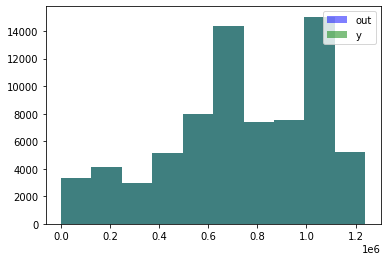

In [ ]:
pred = out.cpu().numpy() if torch.cuda.is_available() else out.numpy()
true = data.y.cpu().numpy() if torch.cuda.is_available() else data.y.numpy()

plt.hist(pred, color="b", alpha=0.5, label="out")
plt.hist(true, color="g", alpha=0.5, label="y")

plt.legend(loc='upper right')

In [ ]:
# ----------------------------------------------------------------------
# Transform tensor to graph
data['out'] = out

data['diff'] = torch.abs(data.y - out)

G_out = to_networkx(data, 
                node_attrs=['out', 'y', 'diff'],   # y=Label, distance=v value, value learnt
                to_undirected=True, remove_self_loops=True)    # NOTE: Careful with self loops

Differences


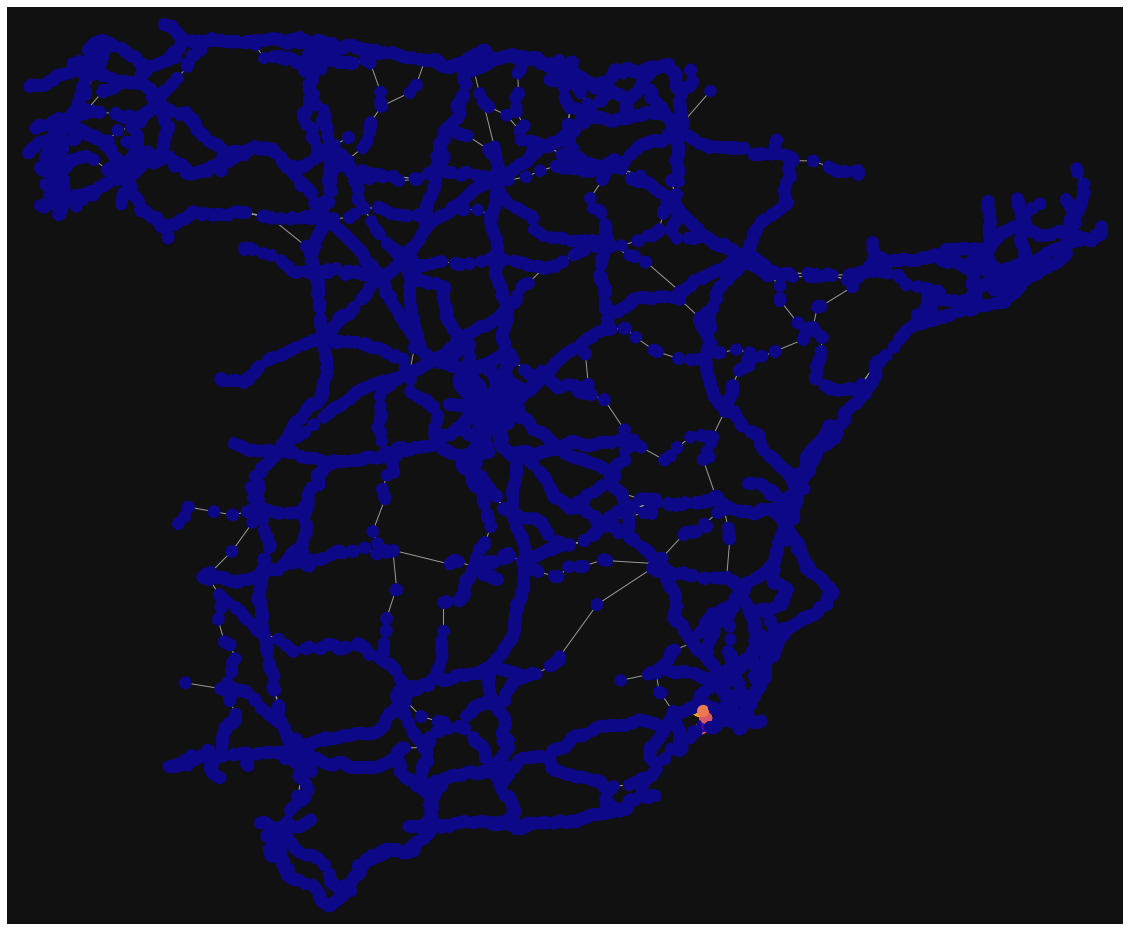

In [ ]:
print("Differences")
_ = plot_heatmap(G_out, G_original, "diff")

Learnt graph


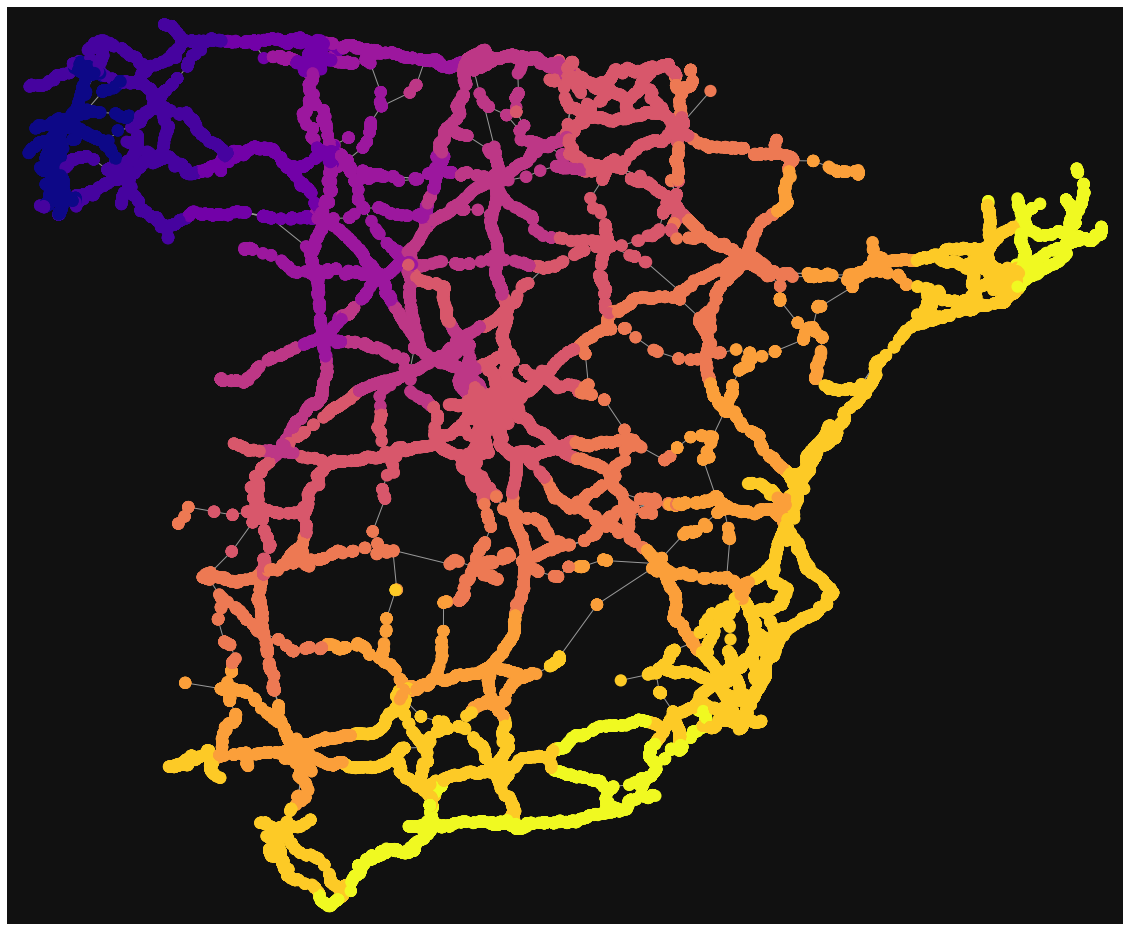

In [ ]:
print("Learnt graph")
_ = plot_heatmap(G_out, G_original, "out")

True graph


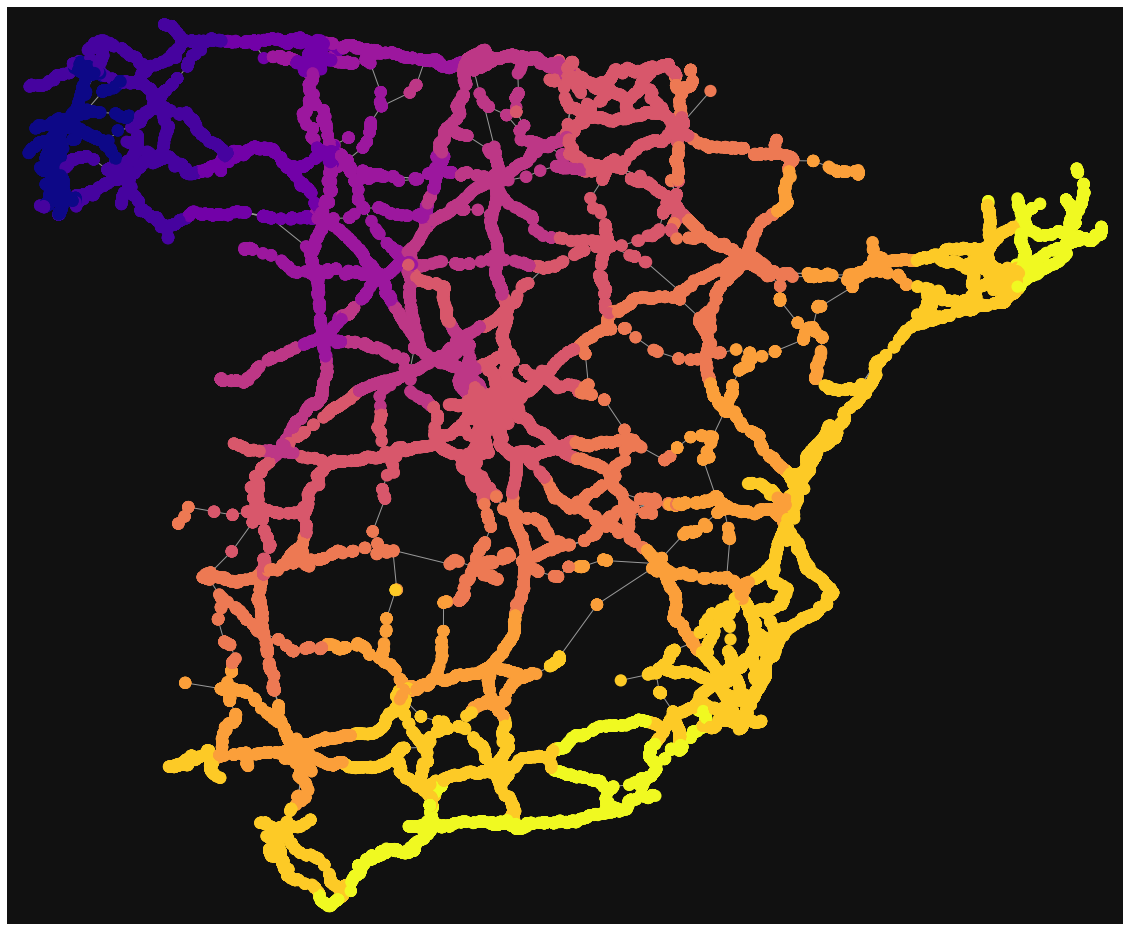

In [ ]:
print("True graph")
_ = plot_heatmap(G_out, G_original, "y")